# PIPELINE 
of the manuscript of 
### 'Identification of mutations in SARS-CoV-2 PCR primer regions' 
### by Anikó Mentes, Krisztián Papp, Dávid Visontai, József Stéger, VEO Technical Working Group, István Csabai, Anna Medgyes-Horváth, and Orsolya Anna Pipek

#### Abstract
Due to the constantly increasing number of mutations in the SARS-CoV-2 genome, concerns have emerged over the possibility of decreased diagnostic accuracy of reverse transcription-polymerase chain reaction (RT-PCR), the gold standard diagnostic test for SARS-CoV-2. We propose an analysis pipeline to discover genomic variations overlapping the target regions of commonly used PCR primer sets. We provide the list of these mutations in a publicly available format based on a dataset of more than 600,000 SARS-CoV-2 samples. Our approach distinguishes among mutations possibly having a damaging impact on PCR efficiency and ones anticipated to be neutral in this sense. Samples are categorized as „prone to misclassification” vs. „likely to be correctly detected” by a given PCR primer set based on the estimated effect of mutations present. Samples susceptible to misclassification are always present at a daily rate of 2% or lower, while the daily ratio of samples having a slight chance of misclassification with a particular primer set can reach 90%. As different variant strains may temporarily gain dominance in the worldwide SARS-CoV-2 viral population, the efficiency of a particular PCR primer set may change over time, therefore constant monitoring of variations in primer target regions is highly recommended.



### Import modules

In [1]:
import psycopg2 # PostgreSQL database adapter

import pandas as pd # data analysis and manipulation tool
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import time
from datetime import datetime, date
from collections import Counter


from  matplotlib import pyplot # visualization tool
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as tkr

import sys, os
from os import listdir
from os.path import isfile, join
sys.path.append('/v/anikomentes/p3_packages/labellines/')
import labellines as LL

import seaborn as sns #  visualization tool
sns.set(style='whitegrid')
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
sns.set_context("notebook", rc={"font.size":16,"axes.titlesize":12,"axes.labelsize":12})

sys.path.append('/v/anikomentes/p3_packages/dna_feature_viewer/')
from dna_features_viewer import BiopythonTranslator
from dna_features_viewer import GraphicFeature, GraphicRecord
from Bio import SeqIO

### Number of all investigated samples 

In [2]:
url = 'https://raw.githubusercontent.com/csabaiBio/coveo_pcr_primers2021/main/basetable_and_example/all_samples220808.csv'
df0 = pd.read_csv(url)
number_all = df0.iloc[0]['count']
print(number_all)

df0 = df0.iloc[: , 1:]
num_var = dict(zip(df0.columns, df0.iloc[0].tolist()))
print(num_var)

665325
{'Alpha': 152891, 'Beta': 2664, 'Gamma': 4219, 'Delta': 367727, 'Omicron': 2459, 'Other variant': 135365}


### Datasets

Samples

In [3]:
url = 'https://raw.githubusercontent.com/csabaiBio/coveo_pcr_primers2021/main/basetable_and_example/Base_table_samples.csv'
df_samples = pd.read_csv(url)

Positions-Primers

In [4]:
url = 'https://raw.githubusercontent.com/csabaiBio/coveo_pcr_primers2021/main/basetable_and_example/Base_table_primers.csv'
df_primers = pd.read_csv(url)

Variants

In [5]:
url = 'https://raw.githubusercontent.com/csabaiBio/coveo_pcr_primers2021/main/basetable_and_example/variants220808.csv'
df_variants = pd.read_csv(url)

Collection_date

In [6]:
url = 'https://raw.githubusercontent.com/csabaiBio/coveo_pcr_primers2021/main/basetable_and_example/dates220808.csv'
df_dates = pd.read_csv(url)

Daily incoming samples

In [7]:
url = 'https://raw.githubusercontent.com/csabaiBio/coveo_pcr_primers2021/main/basetable_and_example/incoming_samples220808.csv'
df_incoming = pd.read_csv(url)

Pcr primers

In [8]:
url = 'https://raw.githubusercontent.com/pkrisz5/vcf_database/main/data/pcr_primers.tsv'
pcr_primers = pd.read_csv(url, sep='\t')

pcr_primers['len_sequence'] = pcr_primers.apply(lambda row: [x for x in range (1,len(row.target_sequence)+1)], axis = 1)

pcr_primers['pos'] = pcr_primers.apply(lambda row: [row.target_sequence_start_pos+x-1 for x in range (1,len(row.target_sequence)+1)] if (row.type == 'F' or row.type == 'probe') else [row.target_sequence_end_pos-x+1 for x in range (1,len(row.target_sequence)+1)], axis = 1)

pcr_primers['target_sequence'] = pcr_primers.apply(lambda row: list(row.target_sequence), axis = 1)

Number of TRs

In [9]:
pp = pcr_primers[['primer_set', 'primer_name']].drop_duplicates().groupby('primer_set').count()
pp.reset_index(inplace=True)
pp.columns = ['primer_set', 'no_of_tg']

Mutation rate

In [10]:
url = 'https://raw.githubusercontent.com/csabaiBio/coveo_pcr_primers2021/main/basetable_and_example/mutation_rate220808.csv'
cov_all = pd.read_csv(url, index_col = 0)

Merge

In [11]:
df_all = pd.merge(df_samples,df_primers)
df_all = df_all.assign(ena_run=df_all['ena_run'].str.split(', ')).explode('ena_run')
df_variants = df_variants.assign(ena_run=df_variants['ena_run'].str.split(', ')).explode('ena_run')
df_all = pd.merge(df_all, df_variants)
print(df_all.shape)
df_all.head()

(3781378, 9)


,ref,pos,alt,ena_run,risk_pos,primer_set,primer,type,variant_id
0,A,808,C,ERR6722191,0,Davi-set,Davi-ORF1a-1,F,Delta
1,C,21618,G,ERR6722191,0,Sarkar-set,Sarkar-S,F,Delta
2,G,15451,A,ERR6722191,0,Tombuloglu-set,Tombuloglu-RdRp,F,Delta
3,G,15451,A,ERR6722191,1,Niu-set,Niu-RdRp,F,Delta
4,G,15451,A,ERR6722191,0,Won-set,Won-RdRp-1,F,Delta


sort_df

In [12]:
# primer_system

tt_ = df_all[['ena_run', 'primer']].drop_duplicates().groupby(['primer']).count().sort_values(by=['ena_run'], ascending=False)
tt_.reset_index(inplace=True)
tt_.columns = ['primer_name','count']
tt_.head()

sorter2 = list(tt_['primer_name'])
sorterIndex2 = dict(zip(sorter2, range(len(sorter2))))

# primer_set

tt_1 = df_all[['ena_run', 'primer_set', 'primer']].drop_duplicates().groupby(['primer_set']).count().sort_values(by=['ena_run'], ascending=False)
tt_1.reset_index(inplace=True)
tt_1 = tt_1[['primer_set','ena_run']]
tt_1.columns = ['primer_set','count']
tt_1.head()

sorter1 = list(tt_1['primer_set'])
sorterIndex1 = dict(zip(sorter1, range(len(sorter1))))

# primer_set + primer_system

tt_2 = df_all[['ena_run', 'primer_set', 'primer']].drop_duplicates().groupby(['primer_set', 'primer']).count().sort_values(by=['ena_run'], ascending=False)
tt_2.reset_index(inplace=True)
tt_2.columns = ['primer_set', 'primer_name', 'count']
tt_2['h_sample%'] = tt_2['count'] / number_all 

tt_2['Rank1'] = tt_2['primer_set'].map(sorterIndex1)
tt_2['Rank2'] = tt_2['primer_name'].map(sorterIndex2)

tt_2.sort_values(['Rank1', 'Rank2'],
        ascending = [True, True], inplace = True)
tt_2.drop('Rank1', 1, inplace = True)
tt_2.drop('Rank2', 1, inplace = True)

asd1 = pd.unique(tt_2['primer_set'])
tt_2.head()

,primer_set,primer_name,count,h_sample%
0,Niu-set,Niu-N,492399,0.740088
1,Niu-set,Niu-RdRp,368998,0.554613
40,Niu-set,Niu-ORF1ab,4698,0.007061
48,Niu-set,Niu-E,2943,0.004423
4,Won-set,Won-RdRp-1,366911,0.551476


### Number of samples affected by a genomic variation in at least one investigated TR

In [13]:
df_g1 = df_all[['ena_run', 'variant_id']].drop_duplicates()
print('Number of all sample:', df_g1.shape[0])

var_num = 0
for variant in ('Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron'):
    var_num1 = df_g1[df_g1['variant_id'] == variant].shape[0]
    var_num += var_num1

    print('Number of '+variant+' variant in the samples:', var_num1)
    
    
print('Number of other variants in the samples:', df_g1.shape[0]-var_num)

Number of all sample: 639779
Number of Alpha variant in the samples: 151867
Number of Beta variant in the samples: 2623
Number of Gamma variant in the samples: 4173
Number of Delta variant in the samples: 364983
Number of Omicron variant in the samples: 2443
Number of other variants in the samples: 113690


### TOP MUTATIONS

In [14]:
df_top = df_all[['ena_run', 'variant_id', 'primer', 'alt', 'pos', 'ref', 'type', 'risk_pos']].drop_duplicates()
df_top['primer'] = df_top['primer'] +"-"+ df_top['type']
df_top = df_top[['ena_run', 'variant_id', 'primer', 'alt', 'pos', 'ref', 'risk_pos']].drop_duplicates()
#display(df_top.head())

df_top = df_top.groupby(['primer', 'alt', 'pos', 'ref', 'risk_pos']).count()
df_top.reset_index(inplace=True)
#display(df_top.head())

df_top1 = df_top.groupby(['alt', 'pos', 'ref', 'risk_pos']).agg({"primer": lambda x: ', '.join(x), 'ena_run': lambda x: sum(x)})
df_top1.reset_index(inplace=True)
df_top1 = df_top1.sort_values(by=['ena_run'], ascending=False)

df_top1['cnt'] = df_top1.apply(lambda row: row.ena_run / len(row.primer.split(', ')), axis = 1)
df_top1['ratio'] = df_top1.apply(lambda row: row.cnt / number_all * 100, axis = 1)
top_mut = df_top1.head(10)

In [15]:
for alt, pos, ref, ratio, p, risk in zip(top_mut.alt, top_mut.pos, top_mut.ref, top_mut.ratio, top_mut.primer, top_mut.risk_pos):
    print('Mutant:', ref+str(pos)+alt)
    print('-', 'TR regions:', p)
    
    if risk == 1:
        print('-', 'Consequence: high-risk')
        
    else: 
        print('-', 'Consequence: moderate-risk')
        
    print('-', 'Ratio in all samples:', str(round(ratio,2))+'%')
        
    print('-', 'Ratio in WHO variants:')
        
    df_temp = df_all[(df_all['alt'] == alt) & (df_all['pos'] == pos) & (df_all['ref'] == ref)]
    df_temp_1 = df_temp[['variant_id', 'ena_run']].drop_duplicates().groupby('variant_id').count()
    df_temp_1.reset_index(inplace=True)
    cnt_ = 0
    dict_temp = dict()
    
    for var, cnt in zip(df_temp_1.variant_id, df_temp_1.ena_run):
        if var in num_var.keys():
            #print(var, str(round(cnt/num_var[var]*100, 2))+"%")
            dict_temp[var] = round(cnt/num_var[var]*100, 2)
        else:
            cnt_ += cnt
        
        
    #print('Other variant', str(round(cnt_/num_var['Other']*100, 2))+"%")
    dict_temp['Other variant'] = round(cnt_/num_var['Other variant']*100, 2)     
    dict_temp_sorted_keys = sorted(dict_temp, key=dict_temp.get, reverse=True)

    for i in dict_temp_sorted_keys[:-1]:
        if dict_temp[i] < 1 :
            print(i, '(<1%)', end=', ')
        else:
            print(i, '('+str(dict_temp[i])+'%)', end=', ')
            
    if dict_temp[dict_temp_sorted_keys[-1]] < 1 :
        print(dict_temp_sorted_keys[-1], '(<1%)')
    else:
        print(dict_temp_sorted_keys[-1], '('+str(dict_temp[dict_temp_sorted_keys[-1]])+'%)')
        
    print('\n')

Mutant: G15451A
- TR regions: Corman-RdRp-F, Niu-RdRp-F
- Consequence: high-risk
- Ratio in all samples: 54.92%
- Ratio in WHO variants:
Delta (90.32%), Other variant (12.73%), Beta (<1%), Gamma (<1%), Alpha (<1%)


Mutant: G15451A
- TR regions: Tombuloglu-RdRp-F, Won-RdRp-1-F
- Consequence: moderate-risk
- Ratio in all samples: 54.92%
- Ratio in WHO variants:
Delta (90.32%), Other variant (12.73%), Beta (<1%), Gamma (<1%), Alpha (<1%)


Mutant: C21618G
- TR regions: Sarkar-S-F
- Consequence: moderate-risk
- Ratio in all samples: 53.15%
- Ratio in WHO variants:
Delta (89.14%), Other variant (12.84%)


Mutant: C23271A
- TR regions: Davi-S-1-probe, Davi-S-2-probe
- Consequence: moderate-risk
- Ratio in all samples: 23.09%
- Ratio in WHO variants:
Alpha (95.97%), Delta (<1%), Other variant (<1%)


Mutant: G28881T
- TR regions: Niu-N-F
- Consequence: moderate-risk
- Ratio in all samples: 44.5%
- Ratio in WHO variants:
Delta (77.19%), Other variant (5.65%), Alpha (<1%)


Mutant: G28883C
- T

###  AAC-TRIPLET

In [16]:
alt1, alt2, alt3 = 'A', 'A', 'C'
pos1, pos2, pos3 = 28881, 28882, 28883
ref1, ref2, ref3 = 'G', 'G', 'G'

In [17]:
df_temp = df_all[(df_all['alt'] == alt1) & (df_all['pos'] == pos1) & (df_all['ref'] == ref1) |
            (df_all['alt'] == alt2) & (df_all['pos'] == pos2) & (df_all['ref'] == ref2) |
            (df_all['alt'] == alt3) & (df_all['pos'] == pos3) & (df_all['ref'] == ref3)]

df_temp_1 = df_temp[['variant_id', 'ena_run', 'risk_pos']].groupby(['variant_id', 'ena_run']).count()
df_temp_1.reset_index(inplace=True)
df_temp_1 = df_temp_1[df_temp_1['risk_pos'] == 3]

print('Mutant: AAC-triplet')
print('- TR regions: Niu-N-F')
print('- Ratio in all samples:', round((len(df_temp_1) / number_all * 100), 2), '%')
print('- Ratio in WHO variants:')

df_temp_ = df_temp_1[['variant_id', 'ena_run']].groupby('variant_id').count()
df_temp_.reset_index(inplace=True)

cnt_ = 0
dict_temp = dict()
    
for var, cnt in zip(df_temp_.variant_id, df_temp_.ena_run):
    if var in num_var.keys():
        dict_temp[var] = round(cnt/num_var[var]*100, 2)
        
    else:
        cnt_ += cnt


dict_temp['Other variant'] = round(cnt_/num_var['Other variant']*100, 2)     
dict_temp_sorted_keys = sorted(dict_temp, key=dict_temp.get, reverse=True)

for i in dict_temp_sorted_keys[:-1]:
    if dict_temp[i] < 1 :
        print(i, '(<1%)', end=', ')
    else:
        print(i, '('+str(dict_temp[i])+'%)', end=', ')

if dict_temp[dict_temp_sorted_keys[-1]] < 1 :
    print(dict_temp_sorted_keys[-1], '(<1%)')
else:
    print(dict_temp_sorted_keys[-1], '('+str(dict_temp[dict_temp_sorted_keys[-1]])+'%)')

Mutant: AAC-triplet
- TR regions: Niu-N-F
- Ratio in all samples: 23.35 %
- Ratio in WHO variants:
Gamma (87.34%), Alpha (85.44%), Omicron (85.16%), Other variant (1.65%), Beta (<1%), Delta (<1%)


#### Genetic variations / Genomic positions

In [18]:
positions = [item for sublist in pcr_primers.pos for item in sublist]
df_ = pd.DataFrame.from_dict(Counter(positions), orient='index')
df_.reset_index(inplace=True)
df_.columns = ['pos', 'overlap_site']
df__ = df_.merge(df_primers, how='outer')
df__.head()

gv = len(Counter(positions)) - len(df__[df__['alt'].isnull() == True])
gp = len(Counter(positions))
tr = len(pcr_primers[['primer_name']])

print(('\nWe found reliable genetic variations in {} of all {} genomic positions overlapping the {} primer or probe binding sites (TRs) in the investigated SARS-CoV-2 samples.').format(gv, gp, tr))


We found reliable genetic variations in 1826 of all 2188 genomic positions overlapping the 141 primer or probe binding sites (TRs) in the investigated SARS-CoV-2 samples.


#### Most of the mutations affecting the TRs were point mutations

In [19]:
# def

vary = df_all[['ref', 'alt', 'pos']].drop_duplicates()
vary['mutation_type'] = vary.apply(lambda row: 'insertion' if len(row.ref) < len(row.alt) else ('deletion' if len(row.ref) > len(row.alt) else ('transversion' if (row.ref in ('A', 'G') and row.alt in ('C', 'T')) or (row.alt in ('A', 'G') and row.ref in ('C', 'T')) else ('transition' if (row.ref in ('A', 'G') and row.alt in ('A', 'G')) or (row.alt in ('C', 'T') and row.ref in ('C', 'T')) else 'None'))), axis = 1)

# group by
vary = vary.groupby('mutation_type').count()
vary.reset_index(inplace=True)
vary[['mutation_type', 'pos']].head()

mp = dict(zip(vary.mutation_type, vary.pos))
#print(mp)

print('\nMost of the mutations affecting the TRs were point mutations (with a slightly higher frequency of transitions ({}) than transversions ({})), while the numbers of distinct deletions ({}) and insertions ({}) were significantly lower.'.format(mp['transition'], mp['transversion'], mp['deletion'], mp['insertion']))


Most of the mutations affecting the TRs were point mutations (with a slightly higher frequency of transitions (1677) than transversions (1510)), while the numbers of distinct deletions (79) and insertions (23) were significantly lower.


### FIGURE 1

In [20]:
# overlapping df 
df_.head()
print(df_.shape)

# pos series df 
pos_ = pd.DataFrame({'pos':list(range(1,29903+1))})
print(pos_.shape)

# merge
df1_B = pos_.merge(df_, how='outer')
df1_B.columns = ['pos', 'count']
df1_B = df1_B.fillna(0)
print(df1_B.shape)

(2188, 2)
(29903, 1)
(29903, 2)


In [21]:
# cov all df

df1_C1 = cov_all.copy()
df1_C1 = df1_C1.fillna(0)


print(df1_C1.shape)

# only pcr TR cov df

df1_fig = pd.merge(df_,df1_C1,on='pos')
df1_fig = df1_fig[['pos', 'mut_rate']]
df1_C2 = pd.merge(df1_fig, pos_, on='pos',how='right')
df1_C2 = df1_C2.fillna(0)

(29903, 2)


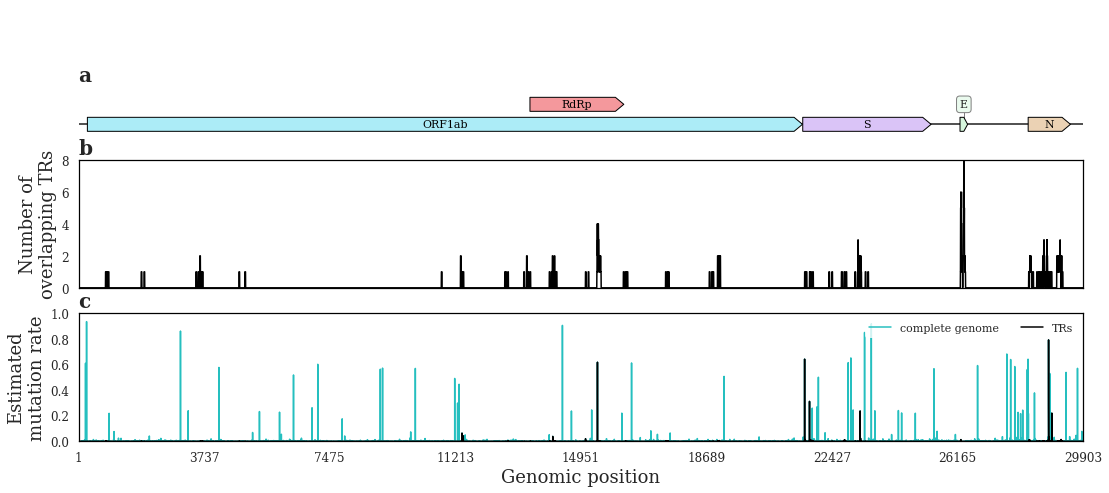

In [22]:
lo = np.arange(-1,29904,3738)
lo = [1] + list(lo[1:])


fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(18, 8), sharex=True, gridspec_kw={"height_ratios": [1, 1, 1]}
)

# PLOT THE RECORD MAP
record = record = GraphicRecord(sequence=29903 * "T", features=[
    GraphicFeature(start=266, end=21555, strand=+1, color="#ACECF7",
                   label="ORF1ab"),
    GraphicFeature(start=13442, end=16236, strand=+1, color="#F4989C",
                   label="RdRp"),
    GraphicFeature(start=21563, end=25384, strand=+1, color="#DAC4F7",
                   label="S"),
    GraphicFeature(start=28274, end=29533, strand=+1, color="#EBD2B4",
                   label="N"),
    GraphicFeature(start=26245, end=26472, strand=+1, color="#D6F6DD",
                   label="E")
])
record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=4)

# PLOT ax2


ax2.grid(False)
ax2.spines['top'].set_visible(True)
ax2.spines["top"].set_color("black")
ax2.spines['bottom'].set_visible(True)
ax2.spines["bottom"].set_color("black")
ax2.spines['right'].set_visible(True)
ax2.spines["right"].set_color("black")
ax2.spines['left'].set_visible(True)
ax2.spines["left"].set_color("black")

ax2.plot(df1_B['pos'], df1_B['count'], color='black')
ax2.set_ylim([0,8])
ax2.set_xlim([1,29903])
ax2.set_xticks(lo) 
ax2.set_xticklabels(lo, fontsize=12)

ax2.set_ylabel("Number of\noverlapping TRs", fontsize=18)
ax2.set_title('b', weight='bold', loc='left', fontsize=20)
ax2.tick_params(axis='y', labelsize=12)


# PLOT ax3
ax3.grid(False)
ax3.spines['top'].set_visible(True)
ax3.spines["top"].set_color("black")
ax3.spines['bottom'].set_visible(True)
ax3.spines["bottom"].set_color("black")
ax3.spines['right'].set_visible(True)
ax3.spines["right"].set_color("black")
ax3.spines['left'].set_visible(True)
ax3.spines["left"].set_color("black")


ax3.plot(df1_C1['pos'], df1_C1['mut_rate'], color='#25BFBF', label='complete genome')
ax3.plot(df1_C2['pos'], df1_C2['mut_rate'], color='black', label='TRs')
ax3.set_ylim([0,1])
ax3.set_ylabel("Estimated\nmutation rate", fontsize=18)
ax3.set_xlabel("Genomic position", fontsize=18)
ax3.set_title('c', weight='bold', loc='left', fontsize=20)
ax3.legend(ncol=2, loc="upper right", edgecolor='none')
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=12)

fig.text(0.125, 0.751, 'a', ha='left', fontsize=20, weight='bold')

#ax3.set_xticklabels(labels)

plt.show()

In [23]:
#labels = [f'{int(item.get_text()):,.0f}' for item in ax3.get_xticklabels()]
#print(labels)

# Run again the above cell

### FIGURE 2 (old version)

In [24]:
# Group by variant, primer, primer set
df_g2A = df_all[['ena_run', 'variant_id', 'primer', 'primer_set']].drop_duplicates().groupby(['variant_id', 'primer', 'primer_set']).count()
df_g2A.reset_index(inplace=True)

# Group by other variant
df_other = df_g2A.query("variant_id not in ('Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron')").groupby(['primer', 'primer_set']).sum()
df_other.reset_index(inplace=True)
df_other['variant_id'] = 'Other variant'

# Select main variant
df_main = df_g2A.query("variant_id in ('Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron')")

# Merge = Fig1 df
dfL = df_main.append(df_other)
dfL.columns = ['variant', 'primer_name', 'primer_set', 'count']
dfL.head()

,variant,primer_name,primer_set,count
0,Alpha,Chan-N,Chan-set,2948
1,Alpha,Chan-RdRp,Chan-set,1013
2,Alpha,Chan-S,Chan-set,1507
3,Alpha,Chu-N,Chu-set,3915
4,Alpha,Chu-ORF1ab,Chu-set,1882


In [25]:
dfL['Rank1'] = dfL['primer_set'].map(sorterIndex1)
dfL['Rank2'] = dfL['primer_name'].map(sorterIndex2)

dfL.sort_values(['Rank1', 'Rank2'],
        ascending = [True, True], inplace = True)
dfL.drop('Rank1', 1, inplace = True)
dfL.drop('Rank2', 1, inplace = True)

dfL['h_sample%'] = dfL['count'] / number_all

dfg = dfL.pivot(index='primer_name', columns='variant', values='h_sample%')
dfg.reset_index(inplace=True)
sorter = list(pd.unique(dfL.primer_name))
sorterIndex = dict(zip(sorter, range(len(sorter))))
dfg['Rank'] = dfg['primer_name'].map(sorterIndex)
dfg.sort_values(['Rank'],
        ascending = [True], inplace = True)
dfg.drop('Rank', 1, inplace = True)

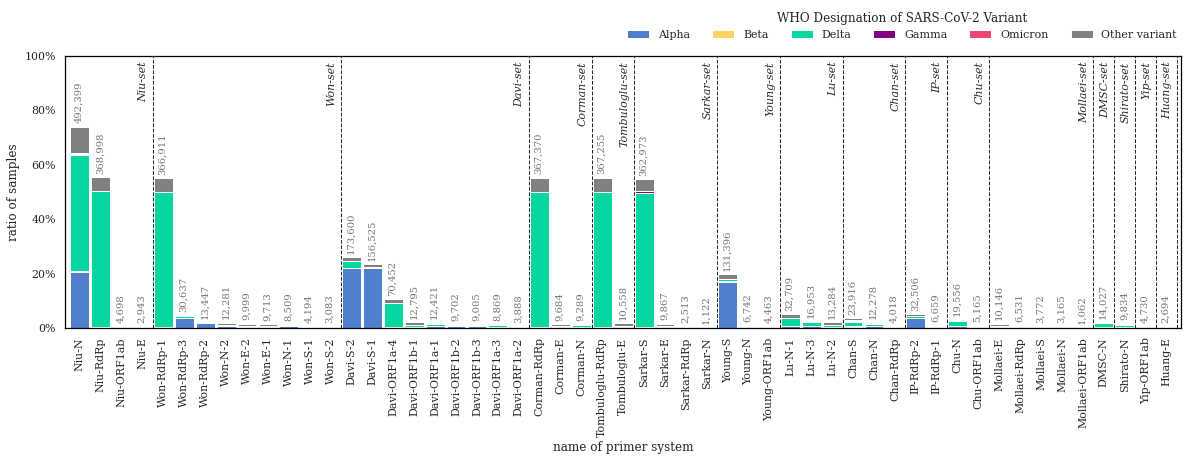

In [26]:
colors=['#4F7FCD', '#ffd166','#06d6a0','purple','#ef476f', 'gray']
genz = list(pd.unique(dfL['variant']))
palette=dict(zip(genz, colors))

#(14,4.5)
g2 = dfg.set_index('primer_name').plot(kind='bar', stacked=True, color=colors, figsize=(20,5), width=0.9)

curtain = list()
j = 0
for i in list(tt_2.groupby('primer_set').count().loc[asd1]['primer_name']):
    j = j + i
    curtain.append(j-0.5)

for i in curtain:
    plt.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
for i,e in enumerate(curtain):
    plt.text(e-0.7, 0.98, asd1[i], style='italic', color='#2A2A2A', rotation=90, verticalalignment='top', fontsize=11)


for i in np.arange(0,len(tt_2),1):
    zz = list(tt_2['h_sample%'])[i]
    plt.text(i-0.25, zz+0.02, f"{list(tt_2['count'])[i] :,}", rotation=90, fontsize=10, color='#757575')
    
#f'{str(list(dfA['hits_ena'])[i]):,.0f}'   
    
plt.ylim(0,1)
#plt.ylim([10**-3,10**0])
#plt.yscale('log')

g2.grid(False)

g2.grid(False)
g2.spines['top'].set_visible(True)
g2.spines["top"].set_color("black")
g2.spines['bottom'].set_visible(True)
g2.spines["bottom"].set_color("black")
g2.spines['right'].set_visible(True)
g2.spines["right"].set_color("black")
g2.spines['left'].set_visible(True)
g2.spines["left"].set_color("black")


#fig = plt.figure()
g2 = plt.gca()
g2.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
g2.set_xlabel("name of primer system", fontsize=12)
g2.set_ylabel("ratio of samples", fontsize=12)

plt.legend(bbox_to_anchor=(1, 1.18), loc=1, ncol=10, borderaxespad=0., title='WHO Designation of SARS-CoV-2 Variant', edgecolor='none') 
plt.show()

### FIGURE 2 (other version)

In [27]:
for variant, cnt in num_var.items():
    if variant != 'Other variant':
        new_column1 = variant+'_nofs'
        new_column2 = variant+'_%ofs'
        mut_cnt_ = num_var[variant]

        dfg[new_column1] = dfg[variant] * number_all
        dfg[new_column2] = dfg[variant] * number_all / mut_cnt_
    else:
        new_column1 = 'Other_nofs'
        new_column2 = 'Other_%ofs'
        mut_cnt_ = num_var[variant]

        dfg[new_column1] = dfg[variant] * number_all
        dfg[new_column2] = dfg[variant] * number_all / mut_cnt_
    
dfg = dfg.fillna(0)

In [28]:
df_F2A = dfg[['primer_name','Alpha_nofs', 'Alpha_%ofs']]
df_F2B = dfg[['primer_name','Beta_nofs', 'Beta_%ofs']]
df_F2G = dfg[['primer_name','Gamma_nofs', 'Gamma_%ofs']]
df_F2D = dfg[['primer_name','Delta_nofs', 'Delta_%ofs']]
df_F2O = dfg[['primer_name','Omicron_nofs', 'Omicron_%ofs']]
df_F2Ot = dfg[['primer_name','Other_nofs', 'Other_%ofs']]
df_F2O.head()

variant,primer_name,Omicron_nofs,Omicron_%ofs
30,Niu-N,2382.0,0.968686
32,Niu-RdRp,3.0,0.001220
31,Niu-ORF1ab,2.0,0.000813
29,Niu-E,1.0,0.000407
44,Won-RdRp-1,3.0,0.001220


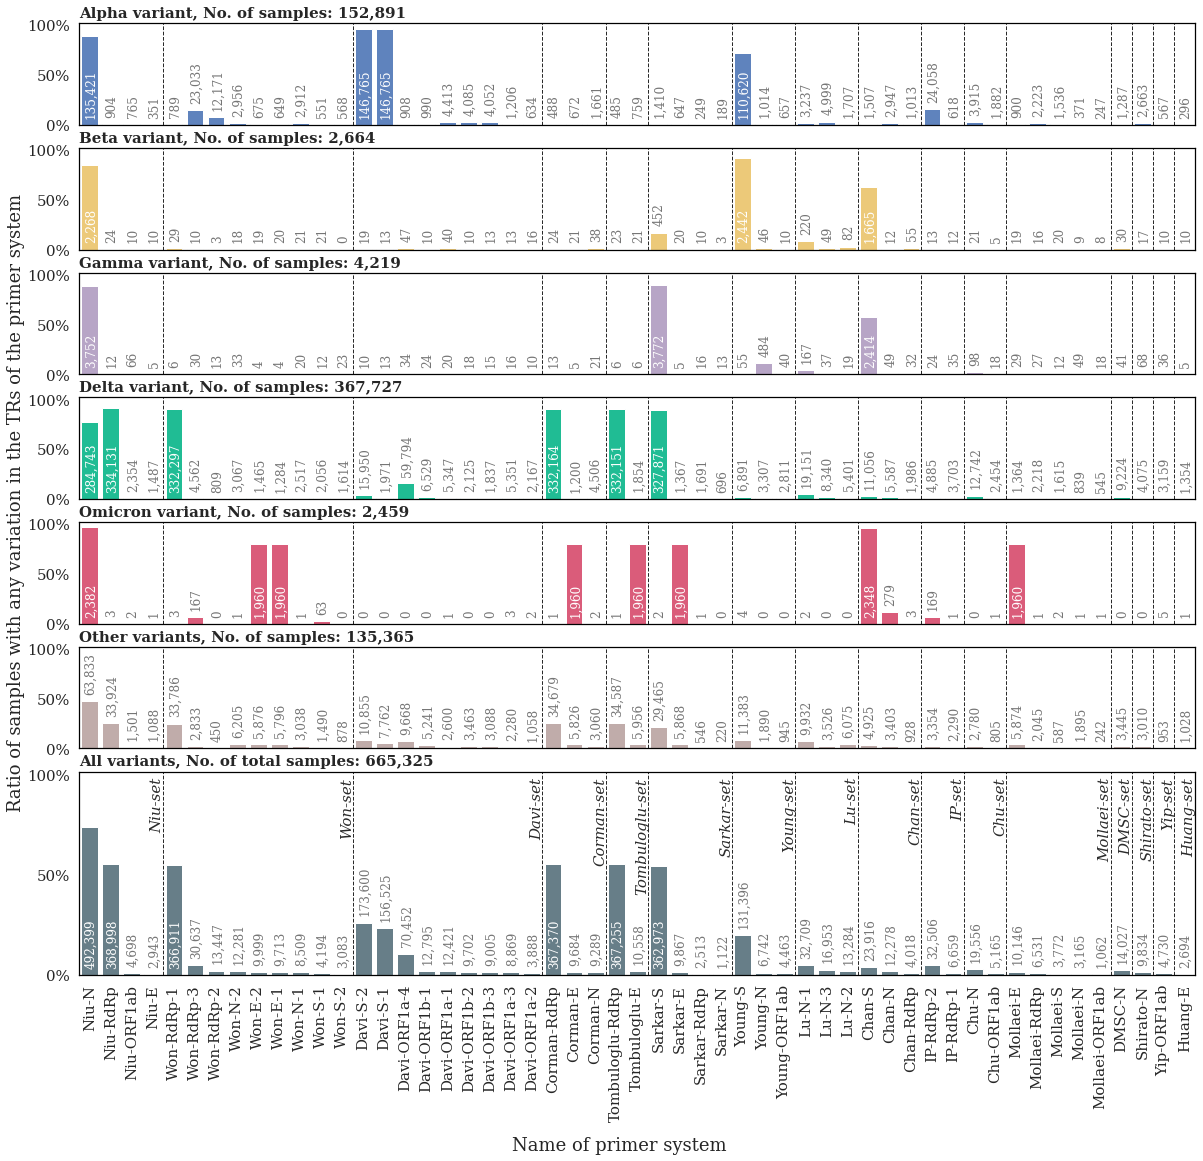

In [29]:
colors=['#4F7FCD', '#ffd166','#06d6a0','#b89fcc','#ef476f', 'gray']

fig, axes = plt.subplots(7, 1, figsize=(20, 17.5), sharey=True, sharex=True, gridspec_kw={'height_ratios': [1,1,1,1,1,1,2]})


#a = sns.barplot(ax=axes[0], x=df_F2A['primer_name'], y=df_F2A['Alpha_%ofs'], color='#4F7FCD', edgecolor='white')
#b = sns.barplot(ax=axes[1], x=df_F2B['primer_name'], y=df_F2B['Beta_%ofs'], color='#ffd166', edgecolor='white')
#c = sns.barplot(ax=axes[2], x=df_F2G['primer_name'], y=df_F2G['Gamma_%ofs'], color='purple', edgecolor='white')
#d = sns.barplot(ax=axes[3], x=df_F2D['primer_name'], y=df_F2D['Delta_%ofs'], color='#06d6a0', edgecolor='white')
#e = sns.barplot(ax=axes[4], x=df_F2O['primer_name'], y=df_F2O['Omicron_%ofs'], color='#ef476f', edgecolor='white')
#f = sns.barplot(ax=axes[5], x=df_F2Ot['primer_name'], y=df_F2Ot['Other_%ofs'], color='gray', edgecolor='white')

a = sns.barplot(ax=axes[0], x=df_F2A['primer_name'], y=df_F2A['Alpha_%ofs'], color='#4F7FCD', edgecolor='white')
b = sns.barplot(ax=axes[1], x=df_F2B['primer_name'], y=df_F2B['Beta_%ofs'], color='#FFD166', edgecolor='white')
c = sns.barplot(ax=axes[2], x=df_F2G['primer_name'], y=df_F2G['Gamma_%ofs'], color='#b89fcc', edgecolor='white')
d = sns.barplot(ax=axes[3], x=df_F2D['primer_name'], y=df_F2D['Delta_%ofs'], color='#06d6a0', edgecolor='white')
e = sns.barplot(ax=axes[4], x=df_F2O['primer_name'], y=df_F2O['Omicron_%ofs'], color='#ef476f', edgecolor='white')
f = sns.barplot(ax=axes[5], x=df_F2Ot['primer_name'], y=df_F2Ot['Other_%ofs'], color='#C4A9A6', edgecolor='white')
g = sns.barplot(ax=axes[6], x=tt_2['primer_name'], y=tt_2['h_sample%'], color='#61818d', edgecolor='white')




L1 = (a, b, c, d, e, f, g)
L2 = ('Alpha variant, No. of samples: 152,891', 'Beta variant, No. of samples: 2,664', 
      'Gamma variant, No. of samples: 4,219', 'Delta variant, No. of samples: 367,727', 
      'Omicron variant, No. of samples: 2,459', 'Other variants, No. of samples: 135,365', 
      'All variants, No. of total samples: 665,325')
L3 = (df_F2A, df_F2B, df_F2G, df_F2D, df_F2O, df_F2Ot, tt_2)
L4 = ('Alpha_nofs', 'Beta_nofs', 'Gamma_nofs', 'Delta_nofs', 'Omicron_nofs', 'Other_nofs', 'count')
L5 = ('Alpha_%ofs', 'Beta_%ofs', 'Gamma_%ofs', 'Delta_%ofs', 'Omicron_%ofs', 'Other_%ofs', 'h_sample%')
 
for ax, var, df, nofs, pofs in zip(L1, L2, L3, L4, L5):
    ax.set_title(var, weight='bold', loc='left', fontsize=15)
    ax.set_xticklabels('')
    ax.set_ylabel('')
    ax.set_xlabel('')
    #ax.set_ylim([10**-3,10**0])
    #ax.set_yscale('log')

    # grid
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
    ax.grid(False)
    ax.spines['top'].set_visible(True)
    ax.spines["top"].set_color("black")
    ax.spines['bottom'].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines['right'].set_visible(True)
    ax.spines["right"].set_color("black")
    ax.spines['left'].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
    #ax.legend().set_visible(False)

    for i in curtain:
        ax.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
    for i in np.arange(0,len(tt_2.primer_name),1):
        if var != 'All variants, No. of total samples: 665,325':
            if list(df[pofs])[i] < 0.48:
                ax.text(i-0.25, list(df[pofs])[i]+0.1, f"{int(list(df[nofs])[i]) :,}", rotation=90, fontsize=12, color='#757575')
            else: 
                ax.text(i-0.25, 0.1, f"{int(list(df[nofs])[i]) :,}", rotation=90, fontsize=12, color='white')

for i in np.arange(0,len(tt_2.primer_name),1):
    if list(df[pofs])[i] < 0.45:
        ax.text(i-0.25, list(df[pofs])[i]+0.05, f"{int(list(df[nofs])[i]) :,}", rotation=90, fontsize=12, color='#757575')
    else: 
        ax.text(i-0.25, 0.05, f"{int(list(df[nofs])[i]) :,}", rotation=90, fontsize=12, color='white')

        
fig.text(0.5, -0.014, 'Name of primer system', ha='center', fontsize=18)
fig.text(0.075, 0.5, 'Ratio of samples with any variation in the TRs of the primer system', va='center', rotation='vertical', fontsize=18)

for i,e in enumerate(curtain):
    ax.text(e-0.6, 0.99, asd1[i], style='italic', color='#2A2A2A', rotation=90, verticalalignment='top', fontsize=15)

        
g.set_xticklabels(df_F2Ot['primer_name'], rotation=90)
plt.show()

### FIGURE 3A

In [30]:
#if we want only variants:

#df_all1 = df_all.query("variant_id not in ('Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron')")

#df_all1 = df_all.query(" variant_id == 'Beta' ")

df_all1 = df_all.copy()

In [31]:
# test - ez a jó
df_g3B = df_all1[['ena_run', 'primer','type', 'risk_pos']].groupby(['primer','type','ena_run']).count()
df_g3B.reset_index(inplace=True)
df_g3B = df_g3B[['ena_run', 'primer', 'risk_pos']].groupby(['primer','ena_run']).max()
df_g3B.reset_index(inplace=True)
#display(df_g3B.sort_values(by=['risk_pos'], ascending=False).head())
df_g3B['A1'] = 1
df_g3B = df_g3B[['primer', 'risk_pos', 'ena_run', 'A1']].groupby(['primer', 'risk_pos']).sum()
df_g3B.reset_index(inplace=True)
df_g3B.head()

,primer,risk_pos,A1
0,Chan-N,1,12246
1,Chan-N,2,32
2,Chan-RdRp,1,4013
3,Chan-RdRp,2,5
4,Chan-S,1,23704


In [32]:
# Group by 3+
df_other = df_g3B.query("risk_pos >= 3").groupby(['primer']).sum()
df_other['risk_pos'] = '3+'
df_other.reset_index(inplace=True)
#display(df_other.head())

# Select 1-2
df_main = df_g3B.query("risk_pos in (1,2) ")
#display(df_main.head())

df1_s3 = df_main.append(df_other)
df1_s3.columns = ['primer', 'hits_pos', 'sum1']
df1_s3.head()

,primer,hits_pos,sum1
0,Chan-N,1,12246
1,Chan-N,2,32
2,Chan-RdRp,1,4013
3,Chan-RdRp,2,5
4,Chan-S,1,23704


In [33]:
df1_s3['sum2'] = df1_s3['sum1'] / number_all
df5 =  df1_s3.pivot(index='primer', columns='hits_pos', values='sum1')
df5.reset_index(inplace=True)
df5.head()
len(df5)

53

In [34]:
tt3 = tt_2.copy()[['primer_name']]
tt3.columns = ['primer']
df5 = df5.merge(tt3, how='outer')
df5 = df5.set_index('primer')
df5.head()

,1,2,3+
primer,,,
Chan-N,12246.0,32.0,NaN
Chan-RdRp,4013.0,5.0,NaN
Chan-S,23704.0,212.0,NaN
Chu-N,19511.0,45.0,NaN
Chu-ORF1ab,5156.0,8.0,1.0


In [35]:
df5.columns = ['1', '2', '3+']
df5 = df5.loc[list(tt_2.primer_name)]
#df5 = df5.iloc[:, ::-1]
display(df5.head())


dfAA = tt_2[['primer_set', 'primer_name']]
dfAA.columns = ['primer_set', 'primer']

df6 = df5.merge(dfAA, how='inner', on='primer')
df6 = df6[['primer', 'primer_set', '3+', '2', '1']]

df6 = df6.melt(id_vars=["primer", "primer_set"], 
    var_name="number of mismatches per sample", 
    value_name="number of samples")
df6 = df6.fillna(0)

df6['number of samples'] = df6['number of samples'].astype(int)
df6['samples%'] = df6['number of samples'] / number_all

df_F2A = df6[df6['number of mismatches per sample'] == '1']
df_F2B = df6[df6['number of mismatches per sample'] == '2']
df_F2C = df6[df6['number of mismatches per sample'] == '3+']

,1,2,3+
primer,,,
Niu-N,326404.0,10559.0,155436.0
Niu-RdRp,368042.0,955.0,1.0
Niu-ORF1ab,4681.0,17.0,NaN
Niu-E,2936.0,7.0,NaN
Won-RdRp-1,365988.0,922.0,1.0


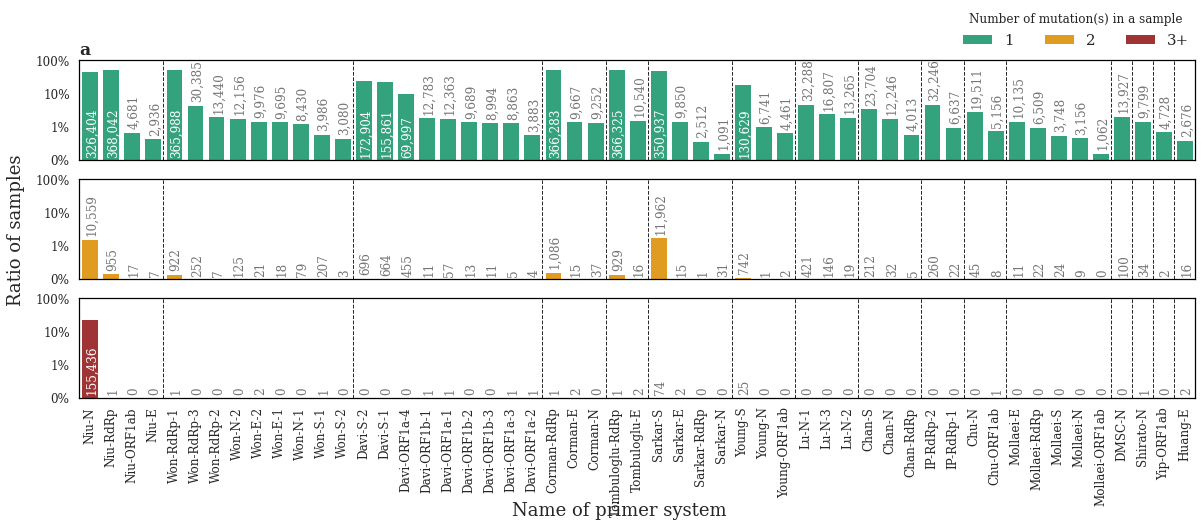

In [36]:
colors=('#B22222', 'orange', '#22B483')
genz = ['3+', '2', '1']
palette=dict(zip(genz, colors))

fig, axes = plt.subplots(3, 1, figsize=(20, 6.2), sharey=True, sharex=True)



a = sns.barplot(ax=axes[0], x=df_F2A['primer'], y=df_F2A['samples%'], hue=df_F2A['number of mismatches per sample'], palette=palette, edgecolor='white')

a.set_xticklabels('')
a.set_ylabel('')
a.set_xlabel('')
a.set_ylim([10**-3,10**0])
a.set_yscale('log')

# grid
a.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
a.grid(False)
a.spines['top'].set_visible(True)
a.spines["top"].set_color("black")
a.spines['bottom'].set_visible(True)
a.spines["bottom"].set_color("black")
a.spines['right'].set_visible(True)
a.spines["right"].set_color("black")
a.spines['left'].set_visible(True)
a.spines["left"].set_color("black")



a.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
a.legend().set_visible(False)

'''a.text(47.0, 1.0, 'A', fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='white', edgecolor='none', pad=3.0))'''


for i in curtain:
    a.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
for i in np.arange(0,len(tt_2.primer_name),1):
    if list(df_F2A['number of samples'])[i] == 0:
        a.text(i-0.2, 0.00145, f"{list(df_F2A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')    
    elif list(df_F2A['number of samples'])[i] < 1:
        a.text(i-0.2, list(df_F2A['samples%'])[i]*1.5, f"{list(df_F2A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
    else:
        if list(df_F2A['number of samples'])[i] > 500 and list(df_F2A['number of samples'])[i] < 40000:
            a.text(i-0.2, list(df_F2A['samples%'])[i]*1.5, f"{list(df_F2A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
        if list(df_F2A['number of samples'])[i] > 40000:
            a.text(i-0.2, 0.00145, f"{list(df_F2A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='white')
        if list(df_F2A['number of samples'])[i] < 500:
            a.text(i-0.2, 0.00145, f"{list(df_F2A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')


a.set_title('a', weight='bold', loc='left', fontsize=17)
a.tick_params(axis='y', labelsize=12)

          
            

# Figure B
            
b = sns.barplot(ax=axes[1], x=df_F2B['primer'], y=df_F2B['samples%'], hue=df_F2B['number of mismatches per sample'], palette=palette, edgecolor='white')

b.set_xticklabels('')
b.set_ylabel('')
b.set_ylim([10**-3,10**0])
b.set_yscale('log')
b.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
b.set_xlabel('')
b.legend().set_visible(False)

'''b.text(47.0, 1.0, 'B', fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='white', edgecolor='none', pad=3.0))'''

# grid
b.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
b.grid(False)
b.spines['top'].set_visible(True)
b.spines["top"].set_color("black")
b.spines['bottom'].set_visible(True)
b.spines["bottom"].set_color("black")
b.spines['right'].set_visible(True)
b.spines["right"].set_color("black")
b.spines['left'].set_visible(True)
b.spines["left"].set_color("black")



for i in curtain:
    b.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
for i in np.arange(0,len(tt_2.primer_name),1):
    if list(df_F2B['number of samples'])[i] > 0:
        if list(df_F2B['number of samples'])[i] > 500 and list(df_F2B['number of samples'])[i] < 40000:
            b.text(i-0.2, list(df_F2B['samples%'])[i]*1.5, f"{list(df_F2B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
        if list(df_F2B['number of samples'])[i] > 40000:
            b.text(i-0.2, 0.00145, f"{list(df_F2B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='white')
        if list(df_F2B['number of samples'])[i] < 500:
            b.text(i-0.2, 0.00145, f"{list(df_F2B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575') 
    else:
        b.text(i-0.2, 0.00145, f"{list(df_F2B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')

        
#b.set_title('B', weight='bold', loc='left', fontsize=15)
b.tick_params(axis='y', labelsize=12)
        
# Figure C        

c = sns.barplot(ax=axes[2], x=df_F2C['primer'], y=df_F2C['samples%'], hue=df_F2C['number of mismatches per sample'], palette=palette, edgecolor='white')

c.set_xticklabels(df_F2C['primer'], rotation=90)
c.set_ylabel('')
c.set_ylim([10**-3,10**0])
c.set_yscale('log')
c.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
c.set_xlabel('')
c.legend().set_visible(False)

'''c.text(47.0, 1.0, 'C', fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='white', edgecolor='none', pad=3.0))'''

# grid
c.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
c.grid(False)
c.spines['top'].set_visible(True)
c.spines["top"].set_color("black")
c.spines['bottom'].set_visible(True)
c.spines["bottom"].set_color("black")
c.spines['right'].set_visible(True)
c.spines["right"].set_color("black")
c.spines['left'].set_visible(True)
c.spines["left"].set_color("black")


for i in curtain:
    c.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
'''for i,e in enumerate(curtain):
    plt.text(e-0.6, 0.85, asd1[i], style='italic', color='#2A2A2A', rotation=90, verticalalignment='top', fontsize=15)
'''
for i in np.arange(0,len(tt_2.primer_name),1):
    if list(df_F2C['number of samples'])[i] > 0:
        if list(df_F2C['number of samples'])[i] > 500 and list(df_F2C['number of samples'])[i] < 40000:
            c.text(i-0.2, list(df_F2C['samples%'])[i]*1.5, f"{list(df_F2C['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
        if list(df_F2C['number of samples'])[i] > 40000:
            c.text(i-0.2, 0.00145, f"{list(df_F2C['number of samples'])[i] :,}", rotation=90, fontsize=12, color='white')
        if list(df_F2C['number of samples'])[i] < 500:
            c.text(i-0.2, 0.00145, f"{list(df_F2C['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575') 
    else:
        c.text(i-0.2, 0.00145, f"{list(df_F2C['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
        
        

fig.text(0.5, -0.14, 'Name of primer system', ha='center', fontsize=18)
fig.text(0.075, 0.5, 'Ratio of samples', va='center', rotation='vertical', fontsize=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, title="Number of mutation(s) in a sample", bbox_to_anchor=(0.9, 1), loc=1, ncol=3, borderaxespad=0., facecolor='white', edgecolor='none', fontsize = 15)

#c.set_title('C', weight='bold', loc='left', fontsize=15)
c.tick_params(axis='x', labelsize=12)
c.tick_params(axis='y', labelsize=12)

plt.show()

### NOT LOGARITMIC

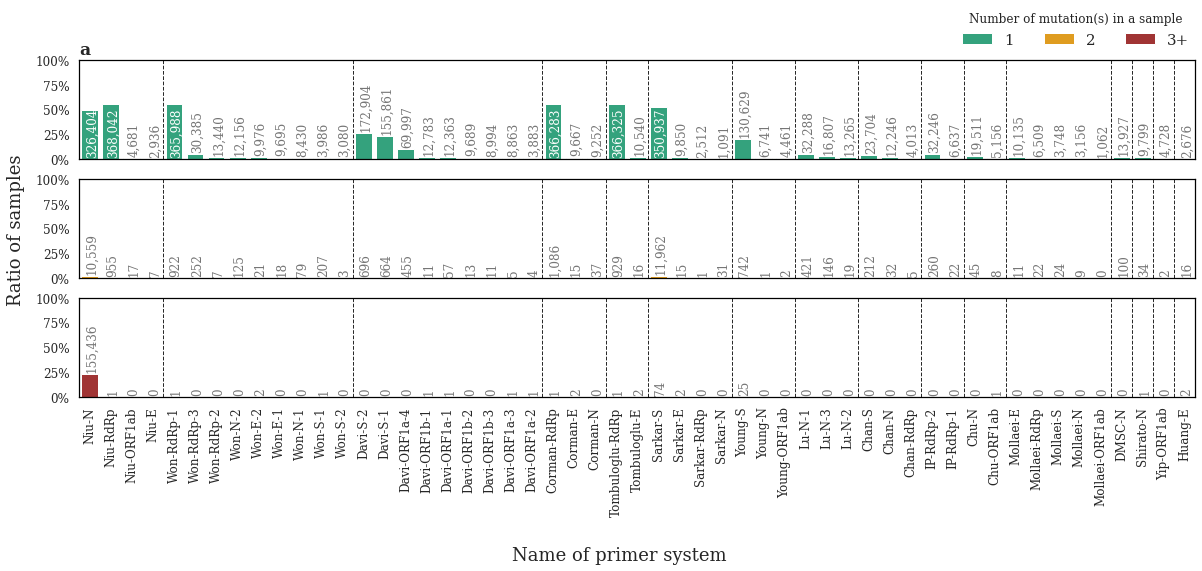

In [37]:
colors=('#B22222', 'orange', '#22B483')
genz = ['3+', '2', '1']
palette=dict(zip(genz, colors))

fig, axes = plt.subplots(3, 1, figsize=(20, 6.2), sharey=True, sharex=True)



a = sns.barplot(ax=axes[0], x=df_F2A['primer'], y=df_F2A['samples%'], hue=df_F2A['number of mismatches per sample'], palette=palette, edgecolor='white')

a.set_xticklabels('')
a.set_ylabel('')
a.set_xlabel('')
#a.set_ylim([10**-3,10**0])
a.set_ylim([0,1])
#a.set_yscale('log')

# grid
a.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
a.grid(False)
a.spines['top'].set_visible(True)
a.spines["top"].set_color("black")
a.spines['bottom'].set_visible(True)
a.spines["bottom"].set_color("black")
a.spines['right'].set_visible(True)
a.spines["right"].set_color("black")
a.spines['left'].set_visible(True)
a.spines["left"].set_color("black")



a.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
a.legend().set_visible(False)

'''a.text(47.0, 1.0, 'A', fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='white', edgecolor='none', pad=3.0))'''


for i in curtain:
    a.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
for i in np.arange(0,len(tt_2.primer_name),1):
    if list(df_F2A['number of samples'])[i] > 300000:
        a.text(i-0.2, 0.05, f"{list(df_F2A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='white')    
    else:
        a.text(i-0.2, list(df_F2A['samples%'])[i]+0.05, f"{list(df_F2A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')

a.set_title('a', weight='bold', loc='left', fontsize=17)
a.tick_params(axis='y', labelsize=12)

          
            

# Figure B
            
b = sns.barplot(ax=axes[1], x=df_F2B['primer'], y=df_F2B['samples%'], hue=df_F2B['number of mismatches per sample'], palette=palette, edgecolor='white')

b.set_xticklabels('')
b.set_ylabel('')
#b.set_ylim([10**-3,10**0])
b.set_ylim([0,1])
#b.set_yscale('log')
b.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
b.set_xlabel('')
b.legend().set_visible(False)

'''b.text(47.0, 1.0, 'B', fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='white', edgecolor='none', pad=3.0))'''

# grid
b.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
b.grid(False)
b.spines['top'].set_visible(True)
b.spines["top"].set_color("black")
b.spines['bottom'].set_visible(True)
b.spines["bottom"].set_color("black")
b.spines['right'].set_visible(True)
b.spines["right"].set_color("black")
b.spines['left'].set_visible(True)
b.spines["left"].set_color("black")



for i in curtain:
    b.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
for i in np.arange(0,len(tt_2.primer_name),1):
    if list(df_F2B['number of samples'])[i] > 300000:
        b.text(i-0.2, 0.05, f"{list(df_F2B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
    else:
        b.text(i-0.2, list(df_F2B['samples%'])[i]+0.05, f"{list(df_F2B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
        
#b.set_title('B', weight='bold', loc='left', fontsize=15)
b.tick_params(axis='y', labelsize=12)
        
# Figure C        

c = sns.barplot(ax=axes[2], x=df_F2C['primer'], y=df_F2C['samples%'], hue=df_F2C['number of mismatches per sample'], palette=palette, edgecolor='white')

c.set_xticklabels(df_F2C['primer'], rotation=90)
c.set_ylabel('')
#c.set_ylim([10**-3,10**0])
c.set_ylim([0,1])
#c.set_yscale('log')
c.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
c.set_xlabel('')
c.legend().set_visible(False)

'''c.text(47.0, 1.0, 'C', fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='white', edgecolor='none', pad=3.0))'''

# grid
c.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
c.grid(False)
c.spines['top'].set_visible(True)
c.spines["top"].set_color("black")
c.spines['bottom'].set_visible(True)
c.spines["bottom"].set_color("black")
c.spines['right'].set_visible(True)
c.spines["right"].set_color("black")
c.spines['left'].set_visible(True)
c.spines["left"].set_color("black")


for i in curtain:
    c.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
'''for i,e in enumerate(curtain):
    plt.text(e-0.6, 0.85, asd1[i], style='italic', color='#2A2A2A', rotation=90, verticalalignment='top', fontsize=15)
'''
for i in np.arange(0,len(tt_2.primer_name),1):
    if list(df_F2C['number of samples'])[i] > 300000:
        c.text(i-0.2, 0.05, f"{list(df_F2C['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
    else:
        c.text(i-0.2, list(df_F2C['samples%'])[i]+0.05, f"{list(df_F2C['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
        
fig.text(0.5, -0.24, 'Name of primer system', ha='center', fontsize=18)
fig.text(0.075, 0.5, 'Ratio of samples', va='center', rotation='vertical', fontsize=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, title="Number of mutation(s) in a sample", bbox_to_anchor=(0.9, 1), loc=1, ncol=3, borderaxespad=0., facecolor='white', edgecolor='none', fontsize = 15)

#c.set_title('C', weight='bold', loc='left', fontsize=15)
c.tick_params(axis='x', labelsize=12)
c.tick_params(axis='y', labelsize=12)

plt.show()

### FIGURE 3B

In [38]:
df_g3A = df_all1[['ena_run', 'primer', 'primer_set', 'risk_pos']].groupby(['primer', 'primer_set', 'ena_run']).sum()
df_g3A.reset_index(inplace=True)
df_g3A.head()

,primer,primer_set,ena_run,risk_pos
0,Chan-N,Chan-set,ERR5090400,0
1,Chan-N,Chan-set,ERR5178607,0
2,Chan-N,Chan-set,ERR5178717,1
3,Chan-N,Chan-set,ERR5179481,1
4,Chan-N,Chan-set,ERR5179783,1


In [39]:
def sort_pictures_col(tg1):
    sorter = list(tt_2['primer_name'])
    sorterIndex = dict(zip(sorter, range(len(sorter))))
    tg1['Rank'] = tg1['case'].map(sorterIndex)
    tg1.sort_values(['Rank'],
        ascending = [True], inplace = True)
    tg1.drop('Rank', 1, inplace = True)
    
    return tg1

# moderate risk_pos

df_m = df_g3A[df_g3A['risk_pos'] == 0].groupby(['primer_set', 'primer']).count()
df_m.reset_index(inplace=True)

tg1A = df_m[['primer', 'ena_run']]


tt3 = tt_2.copy()[['primer_name']]
tt3.columns = ['primer']
tg1A = tg1A.merge(tt3, how='outer')



tg1A.columns = ['case', 'number of samples']
tg1A['sample%'] = tg1A['number of samples'] / number_all
tg1A['magnitude of risk'] = 'moderate risk variants only'
tg1A = sort_pictures_col(tg1A)

# high risk_pos

df_h = df_g3A[df_g3A['risk_pos'] > 0].groupby(['primer_set', 'primer']).count()
df_h.reset_index(inplace=True)

tg1B = df_h[['primer', 'ena_run']]
tg1B = tg1B.merge(tt3, how='outer')


tg1B.columns = ['case', 'number of samples']
tg1B['sample%'] = tg1B['number of samples'] / number_all
tg1B['magnitude of risk'] = 'high risk variant(s)'
tg1B = sort_pictures_col(tg1B)
tg1B.head()

,case,number of samples,sample%,magnitude of risk
30,Niu-N,3108,0.004671,high risk variant(s)
32,Niu-RdRp,367589,0.552495,high risk variant(s)
31,Niu-ORF1ab,822,0.001235,high risk variant(s)
29,Niu-E,948,0.001425,high risk variant(s)
44,Won-RdRp-1,1810,0.002720,high risk variant(s)


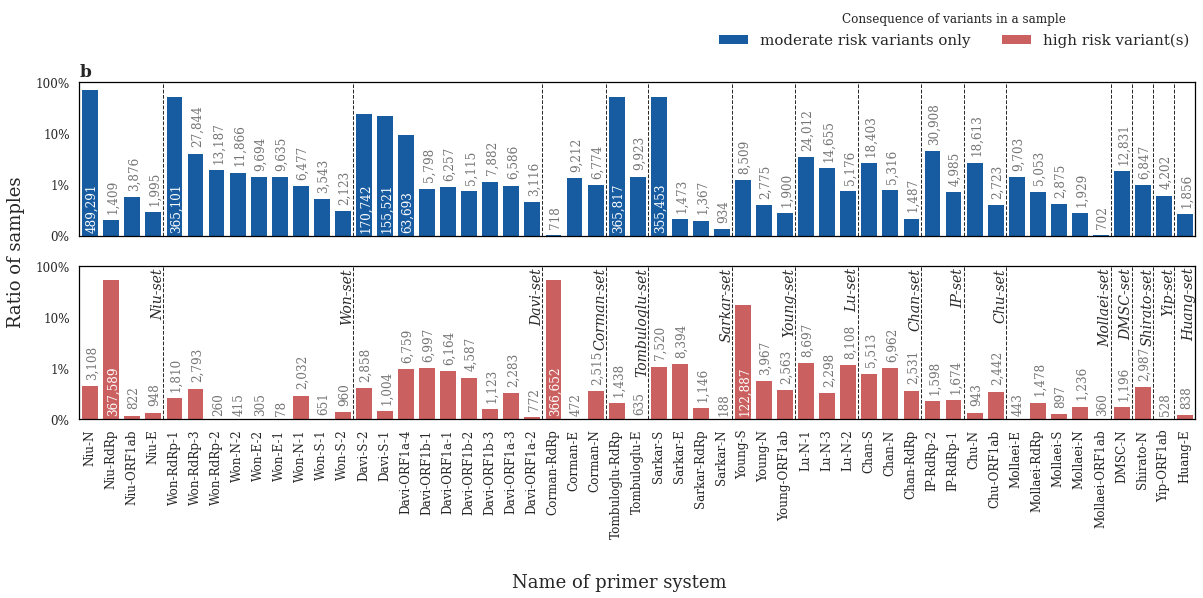

In [40]:
colors=('#005CB8', '#DD4E4E')
genz = ['moderate risk variants only', 'high risk variant(s)']
palette=dict(zip(genz, colors))

fig, axes = plt.subplots(2, 1, figsize=(20, 6.2), sharey=True, sharex=True)
#fig.suptitle('Figure 3. Position of variants in the TRs of the primer systems', fontsize=12, weight='bold')


## 1

a = sns.barplot(ax=axes[0], x=tg1A['case'], y=tg1A['sample%'], hue=tg1A['magnitude of risk'], palette=palette, edgecolor='white')

a.set_xticklabels('')
a.set_ylabel('')
a.set_xlabel('')
a.set_ylim([10**-3,10**0])
a.set_yscale('log')


a.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
a.legend().set_visible(False)

'''a.text(47.0, 1.0, 'A', fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='white', edgecolor='none', pad=3.0))'''


# grid
a.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
a.grid(False)
a.spines['top'].set_visible(True)
a.spines["top"].set_color("black")
a.spines['bottom'].set_visible(True)
a.spines["bottom"].set_color("black")
a.spines['right'].set_visible(True)
a.spines["right"].set_color("black")
a.spines['left'].set_visible(True)
a.spines["left"].set_color("black")


for i in curtain:
    a.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
for i in np.arange(0,len(tt_2.primer_name),1):
    if list(tg1A['number of samples'])[i] > 500 and list(tg1A['number of samples'])[i] < 40000:
        a.text(i-0.2, list(tg1A['sample%'])[i]*1.5, f"{list(tg1A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
    if list(tg1A['number of samples'])[i] < 500:
        a.text(i-0.2, 0.00135, f"{list(tg1A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
    if list(tg1A['number of samples'])[i] > 40000:
        a.text(i-0.2, 0.00135, f"{list(tg1A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='white')

        
a.set_title('b', weight='bold', loc='left', fontsize=17)
a.tick_params(axis='y', labelsize=12)



## 2            
            
            
c = sns.barplot(ax=axes[1], x=tg1B['case'], y=tg1B['sample%'], hue=tg1B['magnitude of risk'], palette=palette, edgecolor='white')

c.set_xticklabels(tt_2['primer_name'], rotation=90)
c.set_ylabel('')
c.set_ylim([10**-3,10**0])
c.set_yscale('log')
c.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
c.set_xlabel('')
c.legend().set_visible(False)

'''c.text(47.0, 1.0, 'B', fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='white', edgecolor='none', pad=3.0))'''

# grid
c.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
c.grid(False)
c.spines['top'].set_visible(True)
c.spines["top"].set_color("black")
c.spines['bottom'].set_visible(True)
c.spines["bottom"].set_color("black")
c.spines['right'].set_visible(True)
c.spines["right"].set_color("black")
c.spines['left'].set_visible(True)
c.spines["left"].set_color("black")


for i in curtain:
    c.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
for i,e in enumerate(curtain):
    plt.text(e-0.6, 0.95, asd1[i], style='italic', color='#2A2A2A', rotation=90, verticalalignment='top', fontsize=14)

for i in np.arange(0,len(tt_2.primer_name),1):
    if list(tg1B['number of samples'])[i] > 600 and list(tg1B['number of samples'])[i] < 40000:
        c.text(i-0.2, list(tg1B['sample%'])[i]*1.5, f"{list(tg1B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
    if list(tg1B['number of samples'])[i] < 600:
        c.text(i-0.2, 0.00135, f"{list(tg1B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
    if list(tg1B['number of samples'])[i] > 40000:
        c.text(i-0.2, 0.00135, f"{list(tg1B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='white')


fig.text(0.5, -0.25, 'Name of primer system', ha='center', fontsize=18)
fig.text(0.075, 0.5, 'Ratio of samples', va='center', rotation='vertical', fontsize=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, title="magnitude of risk of the variants in a sample", loc=(0.1, 0), ncol=2, facecolor='white', edgecolor='none')
fig.legend(lines, labels, title="Consequence of variants in a sample", bbox_to_anchor=(0.9, 1.05), loc=1, ncol=2, borderaxespad=0., facecolor='white', edgecolor='none', fontsize=15)

#c.set_title('B', weight='bold', loc='left', fontsize=15)
c.tick_params(axis='x', labelsize=12)
c.tick_params(axis='y', labelsize=12)


plt.show()

### NOT LOGARITMIC

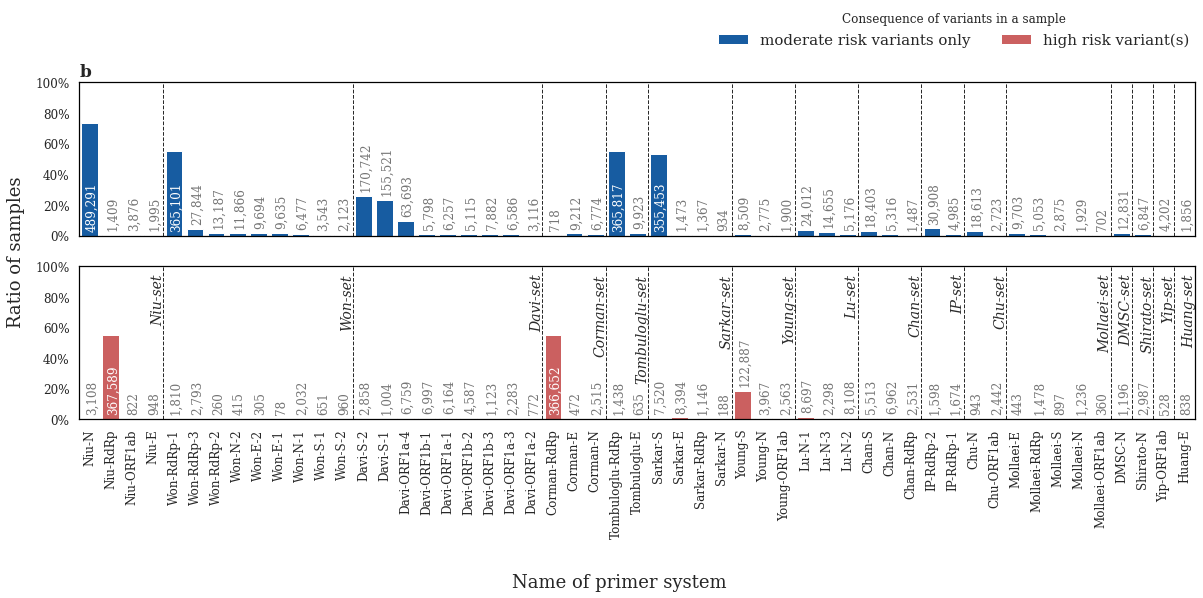

In [41]:
colors=('#005CB8', '#DD4E4E')
genz = ['moderate risk variants only', 'high risk variant(s)']
palette=dict(zip(genz, colors))

fig, axes = plt.subplots(2, 1, figsize=(20, 6.2), sharey=True, sharex=True)
#fig.suptitle('Figure 3. Position of variants in the TRs of the primer systems', fontsize=12, weight='bold')


## 1

a = sns.barplot(ax=axes[0], x=tg1A['case'], y=tg1A['sample%'], hue=tg1A['magnitude of risk'], palette=palette, edgecolor='white')

a.set_xticklabels('')
a.set_ylabel('')
a.set_xlabel('')
#a.set_ylim([10**-3,10**0])
a.set_ylim([0,1])
#a.set_yscale('log')


a.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
a.legend().set_visible(False)

'''a.text(47.0, 1.0, 'A', fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='white', edgecolor='none', pad=3.0))'''


# grid
a.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
a.grid(False)
a.spines['top'].set_visible(True)
a.spines["top"].set_color("black")
a.spines['bottom'].set_visible(True)
a.spines["bottom"].set_color("black")
a.spines['right'].set_visible(True)
a.spines["right"].set_color("black")
a.spines['left'].set_visible(True)
a.spines["left"].set_color("black")


for i in curtain:
    a.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
for i in np.arange(0,len(tt_2.primer_name),1):
    if list(tg1A['number of samples'])[i] > 300000:
        a.text(i-0.2, 0.05, f"{list(tg1A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='white')
    else:
        a.text(i-0.2, list(tg1A['sample%'])[i]+0.05, f"{list(tg1A['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')
        
a.set_title('b', weight='bold', loc='left', fontsize=17)
a.tick_params(axis='y', labelsize=12)



## 2            
            
            
c = sns.barplot(ax=axes[1], x=tg1B['case'], y=tg1B['sample%'], hue=tg1B['magnitude of risk'], palette=palette, edgecolor='white')

c.set_xticklabels(tt_2['primer_name'], rotation=90)
c.set_ylabel('')
#c.set_ylim([10**-3,10**0])
c.set_ylim([0,1])
#c.set_yscale('log')
c.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
c.set_xlabel('')
c.legend().set_visible(False)

'''c.text(47.0, 1.0, 'B', fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='white', edgecolor='none', pad=3.0))'''

# grid
c.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
c.grid(False)
c.spines['top'].set_visible(True)
c.spines["top"].set_color("black")
c.spines['bottom'].set_visible(True)
c.spines["bottom"].set_color("black")
c.spines['right'].set_visible(True)
c.spines["right"].set_color("black")
c.spines['left'].set_visible(True)
c.spines["left"].set_color("black")


for i in curtain:
    c.axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
    
for i,e in enumerate(curtain):
    plt.text(e-0.6, 0.95, asd1[i], style='italic', color='#2A2A2A', rotation=90, verticalalignment='top', fontsize=14)

for i in np.arange(0,len(tt_2.primer_name),1):
    if list(tg1B['number of samples'])[i] > 300000:
        c.text(i-0.2, 0.05, f"{list(tg1B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='white')
    else:
        c.text(i-0.2, list(tg1B['sample%'])[i]+0.05, f"{list(tg1B['number of samples'])[i] :,}", rotation=90, fontsize=12, color='#757575')



fig.text(0.5, -0.25, 'Name of primer system', ha='center', fontsize=18)
fig.text(0.075, 0.5, 'Ratio of samples', va='center', rotation='vertical', fontsize=18)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, title="magnitude of risk of the variants in a sample", loc=(0.1, 0), ncol=2, facecolor='white', edgecolor='none')
fig.legend(lines, labels, title="Consequence of variants in a sample", bbox_to_anchor=(0.9, 1.05), loc=1, ncol=2, borderaxespad=0., facecolor='white', edgecolor='none', fontsize=15)

#c.set_title('B', weight='bold', loc='left', fontsize=15)
c.tick_params(axis='x', labelsize=12)
c.tick_params(axis='y', labelsize=12)


plt.show()

### FIGURE 5

In [42]:
df_dates = df_dates.assign(ena_run=df_dates['ena_run'].str.split(', ')).explode('ena_run')
df_all_d = pd.merge(df_all,df_dates)
print(df_all_d.shape)
df_all_d.head()

(3781378, 10)


,ref,pos,alt,ena_run,risk_pos,primer_set,primer,type,variant_id,collection_date
0,A,808,C,ERR6722191,0,Davi-set,Davi-ORF1a-1,F,Delta,2021-06-08
1,C,21618,G,ERR6722191,0,Sarkar-set,Sarkar-S,F,Delta,2021-06-08
2,G,15451,A,ERR6722191,0,Tombuloglu-set,Tombuloglu-RdRp,F,Delta,2021-06-08
3,G,15451,A,ERR6722191,1,Niu-set,Niu-RdRp,F,Delta,2021-06-08
4,G,15451,A,ERR6722191,0,Won-set,Won-RdRp-1,F,Delta,2021-06-08


In [43]:
df_all = df_all_d[['pos', 'ena_run', 'primer_set', 'primer', 'type', 'risk_pos', 'collection_date']].drop_duplicates()

print(df_all.shape)

df_all.head()

(3781378, 7)


,pos,ena_run,primer_set,primer,type,risk_pos,collection_date
0,808,ERR6722191,Davi-set,Davi-ORF1a-1,F,0,2021-06-08
1,21618,ERR6722191,Sarkar-set,Sarkar-S,F,0,2021-06-08
2,15451,ERR6722191,Tombuloglu-set,Tombuloglu-RdRp,F,0,2021-06-08
3,15451,ERR6722191,Niu-set,Niu-RdRp,F,1,2021-06-08
4,15451,ERR6722191,Won-set,Won-RdRp-1,F,0,2021-06-08


In [44]:
df1 = df_all[['collection_date', 'ena_run', 'primer_set', 'primer', 'type', 'risk_pos']]

df1 = df1.assign(result = np.where(df1['risk_pos']=='0' ,df1['risk_pos'].count(),df1['risk_pos'].sum()))\
   .groupby(['collection_date','ena_run', 'primer_set', 'primer', 'type', 'risk_pos']).agg({'result':'count'})

df1.reset_index(inplace=True)

df1.loc[(df1['risk_pos'] > 0) | (df1['result'] > 2), 'risk_sample'] = 1
df1.loc[(df1['risk_pos'] == 0) & (df1['result'] < 3), 'risk_sample'] = 0
df1 = df1[['collection_date','ena_run', 'primer_set', 'primer', 'type', 'risk_sample']].groupby(['collection_date','ena_run', 'primer_set', 'primer', 'type']).max()

df2 = df1[df1['risk_sample']==1].groupby(['collection_date','ena_run', 'primer_set', 'primer']).count()
df2.reset_index(inplace=True)
df3 = df2[['collection_date','ena_run', 'primer_set', 'primer']]
df = df3.copy()
print(df3.shape)

df3.head()

(1137784, 4)


,collection_date,ena_run,primer_set,primer
0,2021-01-01,ERR5088291,Niu-set,Niu-N
1,2021-01-01,ERR5088291,Young-set,Young-S
2,2021-01-01,ERR5088615,Niu-set,Niu-N
3,2021-01-01,ERR5088615,Young-set,Young-S
4,2021-01-01,ERR5088718,Corman-set,Corman-RdRp


In [45]:
df3 = df3.groupby(['collection_date','ena_run', 'primer_set']).count()

df3.reset_index(inplace=True)

print(df3.shape)

df3.head()

(1129048, 4)


,collection_date,ena_run,primer_set,primer
0,2021-01-01,ERR5088291,Niu-set,1
1,2021-01-01,ERR5088291,Young-set,1
2,2021-01-01,ERR5088615,Niu-set,1
3,2021-01-01,ERR5088615,Young-set,1
4,2021-01-01,ERR5088718,Corman-set,1


In [46]:
df3 = df3.groupby(['collection_date','primer_set', 'primer']).count()
df3.reset_index(inplace=True)
df3.columns = ['collection_date','primer_set', 'systems_number', 'count']

print(df3.shape)

df3.head()

(6810, 4)


,collection_date,primer_set,systems_number,count
0,2021-01-01,Chan-set,1,103
1,2021-01-01,Chan-set,2,2
2,2021-01-01,Chu-set,1,8
3,2021-01-01,Corman-set,1,733
4,2021-01-01,Corman-set,2,1


In [47]:
tg = df3.merge(pp, how='outer')

tg['sample%'] = tg['count'] / number_all

tg = tg[['collection_date','primer_set', 'systems_number', 'count','sample%', 'no_of_tg']]
tg.head()

,collection_date,primer_set,systems_number,count,sample%,no_of_tg
0,2021-01-01,Chan-set,1,103,0.000155,3
1,2021-01-01,Chan-set,2,2,0.000003,3
2,2021-01-02,Chan-set,1,17,0.000026,3
3,2021-01-03,Chan-set,1,22,0.000033,3
4,2021-01-04,Chan-set,1,33,0.000050,3


In [48]:
date_ = pd.DataFrame(pd.date_range(start='1/1/2021', periods=365))
date_.columns = ['collection_date']
date_['collection_date'] = date_['collection_date'].astype(str)

from itertools import product

ds = pd.DataFrame(list(product(pp[['primer_set']]['primer_set'], date_['collection_date'])))
ds.columns = ['primer_set', 'collection_date']
ds.head()

,primer_set,collection_date
0,Chan-set,2021-01-01
1,Chan-set,2021-01-02
2,Chan-set,2021-01-03
3,Chan-set,2021-01-04
4,Chan-set,2021-01-05


In [49]:
ds_ = ds.merge(pp, how='outer')
ds_['systems_number'] = ds_['no_of_tg']
print(ds_.head())
len(ds_)

  primer_set collection_date  no_of_tg  systems_number
0   Chan-set      2021-01-01         3               3
1   Chan-set      2021-01-02         3               3
2   Chan-set      2021-01-03         3               3
3   Chan-set      2021-01-04         3               3
4   Chan-set      2021-01-05         3               3


5840

In [50]:
get_index = -1

for es in pd.unique(ds_.primer_set):
    print(es)
    temp_df = ds_[ds_.primer_set == es]
    full_list = [*range(1,int(pp[pp.primer_set == es].no_of_tg)+1)]
    temp_list = pd.unique(temp_df.systems_number).tolist()
    miss_list= (list(set(full_list) - set(temp_list)))
    #print(miss_list)
    for element in miss_list:
        for date in pd.unique(ds_.collection_date):
            ds_.loc[get_index] = [es,date,int(pp[pp.primer_set == es].no_of_tg),element]
            get_index = get_index-0.1
            #print(element)

Chan-set
Chu-set
Corman-set
DMSC-set
Davi-set
Huang-set
IP-set
Lu-set
Mollaei-set
Niu-set
Sarkar-set
Shirato-set
Tombuloglu-set
Won-set
Yip-set
Young-set


In [51]:
print(len(ds_))
tg1 = tg.merge(ds_, on=['collection_date', 'primer_set', 'systems_number', 'no_of_tg'], how='right')
print(len(tg1))
tg1 = tg1.fillna(0)
tg1.head()

19345
19345


,collection_date,primer_set,systems_number,count,sample%,no_of_tg
0,2021-01-01,Chan-set,3,0.0,0.0,3
1,2021-01-02,Chan-set,3,0.0,0.0,3
2,2021-01-03,Chan-set,3,0.0,0.0,3
3,2021-01-04,Chan-set,3,0.0,0.0,3
4,2021-01-05,Chan-set,3,0.0,0.0,3


In [52]:
tg = tg1.copy()
    
sorter = list(tt_2['primer_set'])
sorterIndex = dict(zip(sorter, range(len(sorter))))
tg['Rank'] = tg['primer_set'].map(sorterIndex)
tg.sort_values(['Rank', 'systems_number'],
        ascending = [True, True], inplace = True)
tg.drop('Rank', 1, inplace = True)

tg['system_case'] = tg['primer_set'] +"-"+ tg['systems_number'].map(str)


#######

test = tg.copy()
test['treshold'] = (test['no_of_tg']*0.5)

In [53]:
test['susceptible'] = test[test['systems_number'] >= test['treshold']].groupby(['collection_date','primer_set'])['count'].transform('sum')
test['slight chance'] = test[test['systems_number'] < test['treshold']].groupby(['collection_date','primer_set'])['count'].transform('sum')
test = test.fillna(0)
test1 = test[['collection_date','primer_set', 'susceptible', 'slight chance']].drop_duplicates()
test1 = test1[['collection_date','primer_set', 'susceptible', 'slight chance']].groupby(by=['collection_date','primer_set']).sum()
test1.reset_index(inplace=True)

In [54]:
df5 = test1.melt(id_vars=["primer_set", "collection_date"], 
    var_name="misclassification", 
    value_name="count")

In [55]:
df5 = df5.merge(df_incoming, on='collection_date')
len(df5)

11680

In [56]:
df5['sample%'] = (df5['count']) / (df5['allpos_count']) * 100 # napi bejövő mintákat majd elosztani !!!!!

In [57]:
import time
from datetime import datetime, date

In [58]:
df5['day30_avg'] = df5.groupby(['misclassification','primer_set'])['sample%'].apply(lambda x: x.rolling(window=29, center=True).mean())
df5['collection_date'] = pd.to_datetime(df5['collection_date'])
df5 = df5.fillna(0)
df5['ts'] = df5['collection_date'].apply(lambda x: int((x.date() - date(1970,1,1)).total_seconds()))
df5['ts1'] = df5['collection_date'].apply(lambda x: int((x.date() - date(1970,1,1)).total_seconds()))

In [59]:
dfF5 = df5.copy()
dfF5 = dfF5[dfF5['misclassification'] == 'slight chance'].append(dfF5[dfF5['misclassification'] == 'susceptible'])
dfF5.head()

,primer_set,collection_date,misclassification,count,allpos_count,sample%,day30_avg,ts,ts1
16,Chan-set,2021-01-01,slight chance,103.0,3469,2.969155,0.0,1609459200,1609459200
17,Chu-set,2021-01-01,slight chance,0.0,3469,0.000000,0.0,1609459200,1609459200
18,Corman-set,2021-01-01,slight chance,733.0,3469,21.130009,0.0,1609459200,1609459200
19,DMSC-set,2021-01-01,slight chance,0.0,3469,0.000000,0.0,1609459200,1609459200
20,Davi-set,2021-01-01,slight chance,260.0,3469,7.494955,0.0,1609459200,1609459200


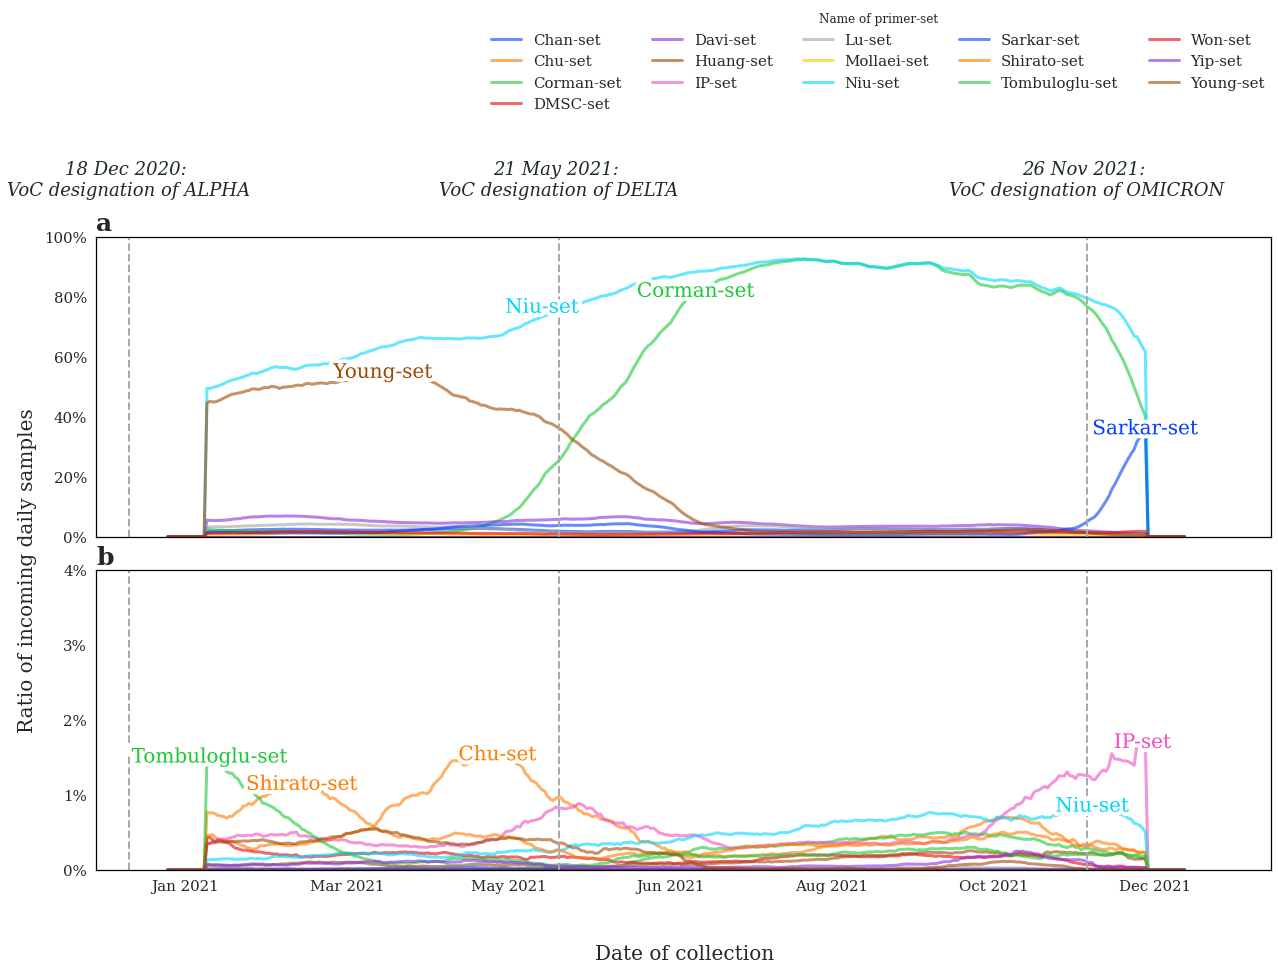

In [60]:
ax1 = sns.FacetGrid(data=dfF5, row='misclassification', palette='bright', height=5, aspect=3.5, hue="primer_set", sharey=False)
ax1.map(pyplot.plot, 'ts1', 'day30_avg', alpha=0.6, linestyle='-', marker='', linewidth=3, markersize=10, markeredgecolor='white')

## ----------------- fig A -----------------

ax1.axes.flat[0].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y:.0f}%'))
ax1.axes.flat[0].grid(False)
ax1.axes.flat[0].spines['top'].set_visible(True)
ax1.axes.flat[0].spines["top"].set_color("black")
ax1.axes.flat[0].spines['bottom'].set_visible(True)
ax1.axes.flat[0].spines["bottom"].set_color("black")
ax1.axes.flat[0].spines['right'].set_visible(True)
ax1.axes.flat[0].spines["right"].set_color("black")
ax1.axes.flat[0].spines['left'].set_visible(True)
ax1.axes.flat[0].spines["left"].set_color("black")
plt.xticks(rotation=0)
ax1.axes.flat[0].set_ylim([0,100])



# --- labellines

lines = ax1.axes.flat[0].get_lines()

for e, w in enumerate(lines):
    
    l1=lines[-1-e]
    
    #print(l1, e)
    
    i = str(l1).split('(')[1].split(')')[0]
    
    #if max(l1.get_ydata()) > 50:
        
    if e == 6:
        LL.labelLine(l1,1621036800,label=r'{}'.format(l1.get_label()),ha='center',va='bottom',align = False, fontsize=20)

    if e == 13:
        LL.labelLine(l1,1625788800,label=r'{}'.format(l1.get_label()),ha='center',va='center',align = False, fontsize=20)

    if e == 5:
        idx = np.where(l1.get_ydata()==max(l1.get_ydata()))
        xdta = l1.get_xdata()[idx]
        LL.labelLine(l1,xdta,label=r'{}'.format(l1.get_label()),ha='center',va='center',align = False, fontsize=20)

    if e == 0:
        idx = np.where(l1.get_ydata()==max(l1.get_ydata()))
        xdta = l1.get_xdata()[idx]
        LL.labelLine(l1,xdta,label=r'{}'.format(l1.get_label()),ha='center',va='center',align = False, fontsize=20)


ax1.axes.flat[0].set_xlabel('')
ax1.axes.flat[0].set_ylabel('')
ax1.axes.flat[0].set_title('')
ax1.axes.flat[0].set_title('a', weight='bold', loc='left', fontsize=25)


ax1.axes.flat[0].axvline(1608249600, alpha=1, color='darkgrey', linestyle='dashed',lw=2)
ax1.axes.flat[0].axvline(1621555200, alpha=1, color='darkgrey', linestyle='dashed',lw=2)
ax1.axes.flat[0].axvline(1637884800, alpha=1, color='darkgrey', linestyle='dashed',lw=2)


## ----------------- fig B -----------------


ax1.axes.flat[1].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y:.0f}%'))
ax1.axes.flat[1].grid(False)
ax1.axes.flat[1].spines['top'].set_visible(True)
ax1.axes.flat[1].spines["top"].set_color("black")
ax1.axes.flat[1].spines['bottom'].set_visible(True)
ax1.axes.flat[1].spines["bottom"].set_color("black")
ax1.axes.flat[1].spines['right'].set_visible(True)
ax1.axes.flat[1].spines["right"].set_color("black")
ax1.axes.flat[1].spines['left'].set_visible(True)
ax1.axes.flat[1].spines["left"].set_color("black")
plt.xticks(rotation=0)
ax1.axes.flat[1].set_ylim([0,4])

# --- labellines

lines = ax1.axes.flat[1].get_lines()

for e, w in enumerate(lines):
    
    l1=lines[-1-e]
    i = lines = ax1.axes.flat[1].get_lines()
    #print('also')
    #print(l1, e)
    
    if max(l1.get_ydata()) > 0.8:
    
        idx = np.where(l1.get_ydata()==max(l1.get_ydata()))

        xdta = l1.get_xdata()[idx]

        LL.labelLine(l1,xdta,label=r'{}'.format(l1.get_label()),ha='center',va='center',align = False, fontsize=20)

        ax1.axes.flat[1].xaxis.set_major_formatter(tkr.FuncFormatter(lambda pos, _: time.strftime("%b %Y", time.localtime(pos))))

        
ax1.axes.flat[1].set_xlim([1609459200,1640908800])
ax1.axes.flat[1].set_xlim([1607249600,1643587200])

ax1.axes.flat[1].set_xlabel('')
ax1.axes.flat[1].set_ylabel('')
ax1.axes.flat[1].set_title('')
ax1.axes.flat[1].set_title('b', weight='bold', loc='left', fontsize=25)

ax1.axes.flat[1].axvline(1608249600, alpha=1, color='darkgrey', linestyle='dashed',lw=2)

ax1.axes.flat[1].axvline(1621555200, alpha=1, color='darkgrey', linestyle='dashed',lw=2)

ax1.axes.flat[1].axvline(1637884800, alpha=1, color='darkgrey', linestyle='dashed',lw=2)


#ax.axvline(1621555200, alpha=1, color='grey', linestyle='dashed',lw=2)

plt.text(1625445600, -1.2, 'Date of collection', ha='center', fontsize=20)
plt.text(1605105600, 4, 'Ratio of incoming daily samples', va='center',ha='center',rotation='vertical', fontsize=20)


plt.text(1608249600, 9, '18 Dec 2020: \nVoC designation of ALPHA', ha='center', color='#1f292e', fontsize=18, style='italic')
plt.text(1621555200, 9, '21 May 2021: \nVoC designation of DELTA', ha='center', color='#1f292e', fontsize=18, style='italic')
plt.text(1637884800, 9, '26 Nov 2021: \nVoC designation of OMICRON', ha='center', color='#1f292e', fontsize=18, style='italic')

#plt.legend(bbox_to_anchor=(1, 5), loc=1, ncol=5, borderaxespad=0., title='Chance of `false negative results` with the Investigated Primer-set on Samples', edgecolor='none') 

#lines_labels = [ax.get_legend_handles_labels() for ax in ax1.axes.flat]
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

lines_labels = [ax.get_legend_handles_labels() for ax in ax1.axes.flat]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

lines_labels2 = dict()
for i in zip(lines, labels):
    lines_labels2[i[1]] = i[0]
    
labels1 = lines_labels2.keys()
lines1 = lines_labels2.values()

plt.legend(lines1, labels1, title='Name of primer-set', bbox_to_anchor=(1, 2.879), loc=1, ncol=5, borderaxespad=0., facecolor='white', edgecolor='none', fontsize=15)

ax1.axes.flat[0].tick_params(axis='both', which='major', labelsize=15)
ax1.axes.flat[1].tick_params(axis='both', which='major', labelsize=15)


start, end = ax1.axes.flat[1].get_ylim()
ax1.axes.flat[1].set_yticks(np.arange(start, end+1, 1))



plt.show()

### Figure 4

In [61]:
df_all = pd.merge(df_samples,df_primers)
df_all = df_all.assign(ena_run=df_all['ena_run'].str.split(', ')).explode('ena_run')
df_variants = df_variants.assign(ena_run=df_variants['ena_run'].str.split(', ')).explode('ena_run')
df_all = pd.merge(df_all, df_variants)

In [62]:
df1 = df_all[['variant_id', 'ena_run', 'primer_set', 'primer', 'type', 'risk_pos']]

df1 = df1.assign(result = np.where(df1['risk_pos']=='0' ,df1['risk_pos'].count(),df1['risk_pos'].sum()))\
   .groupby(['variant_id','ena_run', 'primer_set', 'primer', 'type', 'risk_pos']).agg({'result':'count'})

df1.reset_index(inplace=True)

df1.loc[(df1['risk_pos'] > 0) | (df1['result'] > 2), 'risk_sample'] = 1
df1.loc[(df1['risk_pos'] == 0) & (df1['result'] < 3), 'risk_sample'] = 0
df1 = df1[['variant_id','ena_run', 'primer_set', 'primer', 'type', 'risk_sample']].groupby(['variant_id','ena_run', 'primer_set', 'primer', 'type']).max()

df2 = df1[df1['risk_sample']==1].groupby(['variant_id','ena_run', 'primer_set', 'primer']).count()
df2.reset_index(inplace=True)
df3 = df2[['variant_id','ena_run', 'primer_set', 'primer']]
df = df3.copy()
print(df3.shape)

df3 = df3.groupby(['variant_id','ena_run', 'primer_set']).count()
df3.reset_index(inplace=True)

df3 = df3.groupby(['variant_id','primer_set', 'primer']).count()
df3.reset_index(inplace=True)
df3.columns = ['variant_id','primer_set', 'systems_number', 'count']

# Group by other variant
df_other = df3.query("variant_id not in ('Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron')").groupby(['systems_number', 'primer_set']).sum()
df_other.reset_index(inplace=True)
df_other['variant_id'] = 'Other variant'

# Select main variant
df_main = df3.query("variant_id in ('Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron')")

# Merge = Fig1 df
df3 = df_main.append(df_other)

tg = df3.merge(pp, how='outer')
tg['sample%'] = tg['count'] / number_all
tg = tg[['variant_id','primer_set', 'systems_number', 'count','sample%', 'no_of_tg']]

# sort 
tg['Rank'] = tg['primer_set'].map(sorterIndex1)
tg.sort_values(['Rank', 'systems_number'],
        ascending = [True, True], inplace = True)
tg.drop('Rank', 1, inplace = True)

# case
tg['system_case'] = tg['primer_set'] +"-"+ tg['systems_number'].map(str)


# treshold
test = tg.copy()
test['treshold'] = (test['no_of_tg']*0.5)

(1137784, 4)


In [63]:
test['susceptible'] = test[test['systems_number'] >= test['treshold']].groupby(['variant_id','primer_set'])['count'].transform('sum')
test['slight chance'] = test[test['systems_number'] < test['treshold']].groupby(['variant_id','primer_set'])['count'].transform('sum')
test = test.fillna(0)
test1 = test[['variant_id','primer_set', 'susceptible', 'slight chance']].drop_duplicates()
test1 = test1[['variant_id','primer_set', 'susceptible', 'slight chance']].groupby(by=['variant_id','primer_set']).sum()
test1.reset_index(inplace=True)

In [64]:
df_F6 = test1.melt(id_vars=["primer_set", "variant_id"], 
    var_name="misclassification", 
    value_name="number_of_samples")

df_F6['misclassification'] = df_F6['misclassification'].str.replace('susceptible','susceptible to misclassification')
df_F6['misclassification'] = df_F6['misclassification'].str.replace('slight chance','slight chance of misclassification')

In [65]:
get_index = -1

for variants in num_var.keys():
    print(variants)
    temp_ = df_F6[df_F6['variant_id'] == variants]
    
    #print(temp_)
    
    for es in pd.unique(pp.primer_set):
        # print(es)
        temp_df = temp_[temp_.primer_set == es]
        full_list = ['slight chance of misclassification', 'susceptible to misclassification']
        temp_list = pd.unique(temp_df.misclassification).tolist()
        miss_list= (list(set(full_list) - set(temp_list)))
        for element in miss_list:
            df_F6.loc[get_index] = [es,variants,element,0]
            get_index = get_index-0.1

Alpha
Beta
Gamma
Delta
Omicron
Other variant


In [66]:
mydir = 'https://raw.githubusercontent.com/csabaiBio/coveo_pcr_primers2021/main/basetable_and_example/good_samples/'

onlyfiles = [f+'_good.csv' for f in tt_1.primer_set]

df_F6 = df_F6.fillna(0)

df_all_good = pd.DataFrame(columns = ['variant_id', 'number_of_samples', 'misclassification', 'primer_set'])

for file in onlyfiles:
    #print(file.split('_')[0])
    df_a = pd.read_csv(mydir+file)
    df_a.columns = ['variant_id', 'number_of_samples']
    df_a['misclassification'] = 'no reasonable chance of misclassification'
    df_a['primer_set'] = file.split('_')[0]
    df_all_good = df_all_good.append(df_a)


df_F6 = df_F6.append(df_all_good)
dfall = df_F6[['primer_set', 'misclassification', 'number_of_samples']].groupby(['primer_set', 'misclassification']).sum()
dfall.reset_index(inplace=True)

sorter = list(tt_2['primer_set'])
sorterIndex1 = dict(zip(sorter, range(len(sorter))))

dfall['Rank'] = dfall['primer_set'].map(sorterIndex1)
dfall.sort_values(['Rank', 'misclassification'],
        ascending = [True, True], inplace = True)
dfall.drop('Rank', 1, inplace = True)
dfall['sample%'] = dfall['number_of_samples']/ number_all
dfall.reset_index(inplace=True)

df_F1A = df_F6[df_F6['variant_id'] == 'Alpha']
df_F1A['Rank'] = df_F1A['primer_set'].map(sorterIndex1)
df_F1A.sort_values(['Rank', 'misclassification'],
        ascending = [True, True], inplace = True)
df_F1A.drop('Rank', 1, inplace = True)
df_F1A['sample%'] = df_F1A['number_of_samples']/ num_var['Alpha']
df_F1A.reset_index(inplace=True)




df_F1B = df_F6[df_F6['variant_id'] == 'Beta']
df_F1B['Rank'] = df_F1B['primer_set'].map(sorterIndex1)
df_F1B.sort_values(['Rank', 'misclassification'],
        ascending = [True, True], inplace = True)
df_F1B.drop('Rank', 1, inplace = True)
df_F1B['sample%'] = df_F1B['number_of_samples']/ num_var['Beta']
df_F1B.reset_index(inplace=True)





df_F1C = df_F6[df_F6['variant_id'] == 'Gamma']
df_F1C['Rank'] = df_F1C['primer_set'].map(sorterIndex1)
df_F1C.sort_values(['Rank', 'misclassification'],
        ascending = [True, True], inplace = True)
df_F1C.drop('Rank', 1, inplace = True)
df_F1C['sample%'] = df_F1C['number_of_samples']/ num_var['Gamma']
df_F1C.reset_index(inplace=True)





df_F1D = df_F6[df_F6['variant_id'] == 'Delta']
df_F1D['Rank'] = df_F1D['primer_set'].map(sorterIndex1)
df_F1D.sort_values(['Rank', 'misclassification'],
        ascending = [True, True], inplace = True)
df_F1D.drop('Rank', 1, inplace = True)
df_F1D['sample%'] = df_F1D['number_of_samples']/ num_var['Delta']
df_F1D.reset_index(inplace=True)





df_F1E = df_F6[df_F6['variant_id'] == 'Omicron']
df_F1E['Rank'] = df_F1E['primer_set'].map(sorterIndex1)
df_F1E.sort_values(['Rank', 'misclassification'],
        ascending = [True, True], inplace = True)
df_F1E.drop('Rank', 1, inplace = True)
df_F1E['sample%'] = df_F1E['number_of_samples']/ num_var['Omicron']
df_F1E.reset_index(inplace=True)


df_F1F = df_F6[df_F6['variant_id'] == 'Other variant']
df_F1F['Rank'] = df_F1F['primer_set'].map(sorterIndex1)
df_F1F.sort_values(['Rank', 'misclassification'],
        ascending = [True, True], inplace = True)
df_F1F.drop('Rank', 1, inplace = True)
df_F1F['sample%'] = df_F1F['number_of_samples']/ num_var['Other variant']
df_F1F.reset_index(inplace=True)

<ipython-input-66-22c13b5ab598>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_F1A['Rank'] = df_F1A['primer_set'].map(sorterIndex1)
<ipython-input-66-22c13b5ab598>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_F1A.sort_values(['Rank', 'misclassification'],
/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

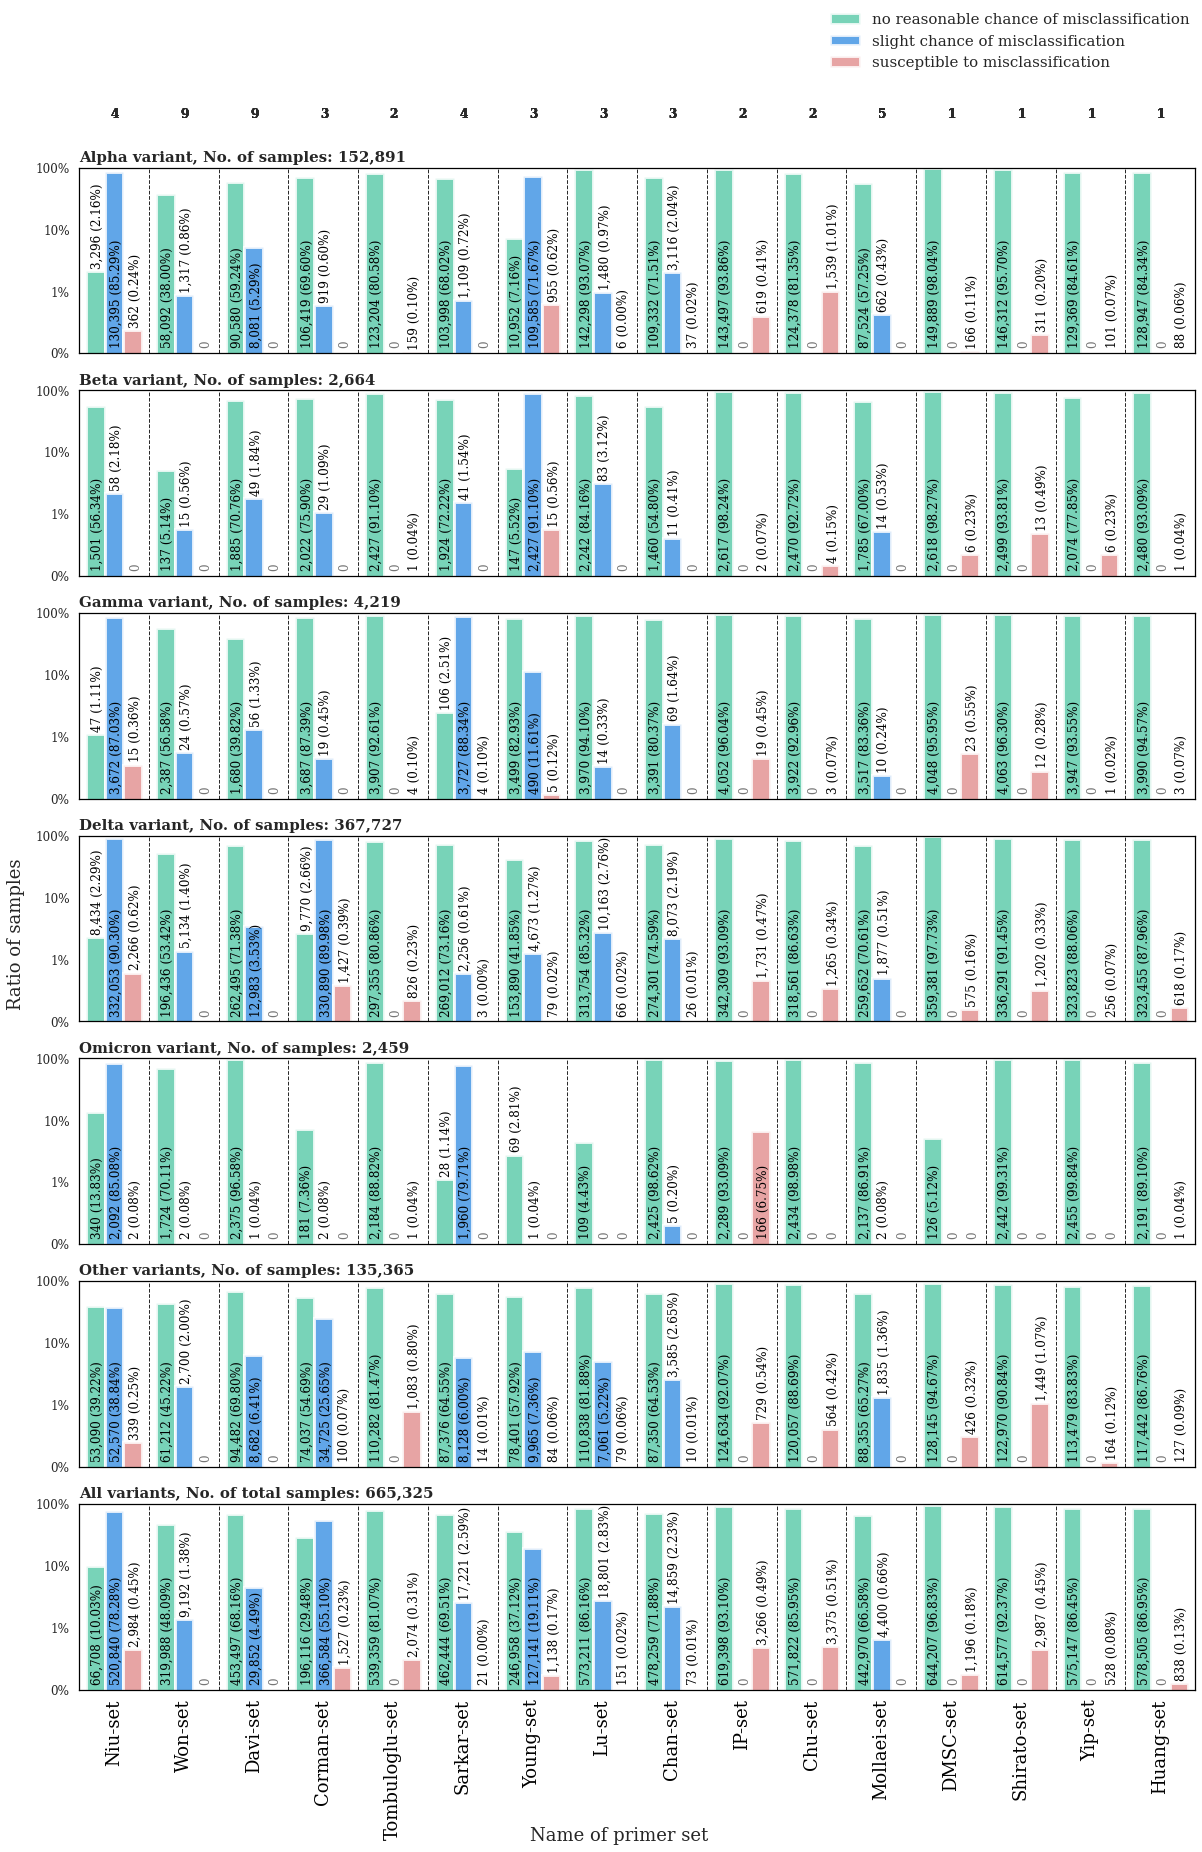

In [67]:
plt.rcParams['legend.title_fontsize'] = 'large'

fig, axes = plt.subplots(7, 1, figsize=(20, 28), sharey=True, sharex=True)

colors=('#43DBAD', 'dodgerblue', 'lightcoral')
genz = ['no reasonable chance of misclassification', 'slight chance of misclassification', 'susceptible to misclassification']
palette=dict(zip(genz, colors))


L1 = (0,1,2,3,4,5,6)
L2 = ('Alpha variant, No. of samples: 152,891', 'Beta variant, No. of samples: 2,664', 
      'Gamma variant, No. of samples: 4,219', 'Delta variant, No. of samples: 367,727', 
      'Omicron variant, No. of samples: 2,459', 'Other variants, No. of samples: 135,365', 
      'All variants, No. of total samples: 665,325')
L3 = (df_F1A, df_F1B, df_F1C, df_F1D, df_F1E, df_F1F, dfall)
L4 = ('#4F7FCD', '#ffd166', 'purple', '#06d6a0', '#ef476f', 'gray', 'black')
L5 = ('Alpha_%ofs', 'Beta_%ofs', 'Gamma_%ofs', 'Delta_%ofs', 'Omicron_%ofs', 'Other_%ofs', 'ALL')
 
for ax1, var, df, nofs, pofs in zip(L1, L2, L3, L4, L5):

    sns.barplot(ax=axes[ax1], data=df,
    x="primer_set", y="sample%", hue="misclassification",
    ci="sd", palette=palette, alpha=.8, dodge = True, edgecolor='white', linewidth=3).legend_.remove()
    
    axes[ax1].set_title(var, weight='bold', loc='left', fontsize=15)
    #axes[ax1].set_xticklabels('')
    axes[ax1].set_ylabel('')
    axes[ax1].set_xlabel('')
    
    #axes[ax1].set_ylim([0,1])
    axes[ax1].set_ylim([10**-3,10**0])
    axes[ax1].set_yscale('log')
    axes[ax1].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f'{y*100:,.0f}%'))
    axes[ax1].grid(False)
    axes[ax1].spines['top'].set_visible(True)
    axes[ax1].spines["top"].set_color("black")
    axes[ax1].spines['bottom'].set_visible(True)
    axes[ax1].spines["bottom"].set_color("black")
    axes[ax1].spines['right'].set_visible(True)
    axes[ax1].spines["right"].set_color("black")
    axes[ax1].spines['left'].set_visible(True)
    axes[ax1].spines["left"].set_color("black")
    
    axes[ax1].tick_params(axis='x', labelsize=12)
    axes[ax1].tick_params(axis='y', labelsize=12)
    
    for i in np.arange(0.5,16,1):
        axes[ax1].axvline([i], 0, 1, color='#2A2A2A', ls="--", linewidth = 1)
        plt.text(i-0.55, 25000000000000000000000, tg[['primer_set', 'no_of_tg']].drop_duplicates()['no_of_tg'].tolist()[int(i-0.5)], rotation=0, fontsize=12, weight='bold', color='#2A2A2A')
        
    for i in np.arange(0,48,3):
        string = str(f"{list(df['number_of_samples'])[i] :,.0f}")+" ("+str(format(round(list(df['sample%'])[i]*100, 3), '.2f'))+"%)"
        
        if df['sample%'][i] == 0:
            axes[ax1].text(i/3-0.33, 0.00135, f"{int(df['number_of_samples'][i]):,}", rotation=90, fontsize=12, color='#757575')
        
        else:
            if (df['sample%'][i] < 0.001) or (df['sample%'][i] > 0.0353):
                axes[ax1].text(i/3-0.33, 0.00135, string, rotation=90, fontsize=12, color='black')
            else:
                axes[ax1].text(i/3-0.33, list(df['sample%'])[i]*1.22, string, rotation=90, fontsize=12, color='black')
        
        '''if df['sample%'][i] == 0:
            axes[ax1].text(i/2-0.28, 0.0022, f"{int(df['number_of_samples'][i]):,}", rotation=90, fontsize=12, color='#757575')
            if df['sample%'][i] > 0.1:
            axes[ax1].text(i/2-0.35, 0.0022, f"{int(df['number_of_samples'][i]):,}", rotation=90, fontsize=12, color='black')
        else:
            axes[ax1].text(i/2-0.28, 0.0022, f"{int(df['number_of_samples'][i]):,}", rotation=90, fontsize=12, color='black')'''
        
    for i in np.arange(1,48,3):
        string = str(f"{list(df['number_of_samples'])[i] :,.0f}")+" ("+str(format(round(list(df['sample%'])[i]*100, 3), '.2f'))+"%)"

        if df['sample%'][i] == 0:
            axes[ax1].text(i/3-0.39, 0.00135, f"{int(df['number_of_samples'][i]):,}", rotation=90, fontsize=12, color='#757575')
        
        else:
            if (df['sample%'][i] < 0.001) or (df['sample%'][i] > 0.0353):
                axes[ax1].text(i/3-0.39, 0.00135, string, rotation=90, fontsize=12, color='black')
            else:
                axes[ax1].text(i/3-0.39, list(df['sample%'])[i]*1.22, string, rotation=90, fontsize=12, color='black')
                
    for i in np.arange(2,48,3):
        string = str(f"{list(df['number_of_samples'])[i] :,.0f}")+" ("+str(format(round(list(df['sample%'])[i]*100, 3), '.2f'))+"%)"

        if df['sample%'][i] == 0:
            axes[ax1].text(i/3-0.45, 0.00135, f"{int(df['number_of_samples'][i]):,}", rotation=90, fontsize=12, color='#757575')
        
        else:
            if (df['sample%'][i] < 0.001) or (df['sample%'][i] > 0.0353):
                axes[ax1].text(i/3-0.45, 0.00135, string, rotation=90, fontsize=12, color='black')
            else:
                axes[ax1].text(i/3-0.45, list(df['sample%'])[i]*1.22, string, rotation=90, fontsize=12, color='black')
        
        
        
        
        
plt.xticks(rotation=90, color='black', fontsize=18)

plt.legend(bbox_to_anchor=(1, 9.065), loc=1, ncol=1, borderaxespad=0., title='', edgecolor='none', fontsize = 15) 

fig.text(0.5, 0.05, 'Name of primer set', ha='center', fontsize=18)
fig.text(0.075, 0.5, 'Ratio of samples', va='center', rotation='vertical', fontsize=18)

plt.show()